# Relating DamID coordination to Hi-C interactions

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
from scipy import stats
from collections import defaultdict
from scipy.signal import gaussian, fftconvolve

import sys
sys.path.append('../../combining_all_data/bin/')
sys.path.append('../bin/')
from preimplantation_toolkit import *
import preimplantation_load_data as ld

rs = np.random.RandomState()
rs.seed(42)

In [2]:
import logging
logging.getLogger('fontTools').setLevel(logging.WARNING)

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

FIGOUTDIR = '../output/figures/2_Preimplantation.LAD_coordination.part2b.coordination_of_PADs/'

In [4]:
! mkdir -p $FIGOUTDIR || true;

In [5]:
HOME = '/Users/f.rang/surfdrive/Kind/data/'

BINSIZE = 100000
MINMAP_PER_KB = 1
MINMAP = int(MINMAP_PER_KB * BINSIZE / 1000)

ANNOFN = '../../combining_all_data/metadata/FR230814.samplesheet.tsv'
COLORFN = '../colors/manuscript_colors.tsv'

COUNTS = '../../combining_all_data/data/damid_counts/FR230814.DamID.sample_counts.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
BINARY = '../../combining_all_data/data/damid_binary/FR230814.DamID.sample_smooth_binary.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
CONTFC = '../../combining_all_data/data/damid_CF/FR230814.DamID.contact_frequency.{construct}.{stage}.{treatment}.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
INSILICO = '../../combining_all_data/data/damid_insilico/FR230814.DamID.insilico_counts.{construct}.{stage}.{treatment}.{genotype}.{sample}_samples.damid_pass.binsize_{binsize:d}.hdf5'
LADS = '../../combining_all_data/data/damid_LADs/FR230814.all_DamID.LAD_calls.{construct}.{stage}.{treatment}.{genotype}.bed.gz'

MAPFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.bowtie2_very_sensitive_N1.readlength_65.counts.pos.hdf5"
POSFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.posarray.hdf5"

CORRFN = '../data/bin_coordination_matrices/FR230814.normalized_bin_coordination_results.smooth_binary_input.PearsonR.Dam-Lmnb1.{stage}.{genotype}.{treatment}.damid_pass.binsize_{binsize:d}.hdf5'
PADFN = '../../GSE118263/data/download/GSE118263.Du2020.TableS2.liftOver_to_mm10.PAD_only.bed'

In [6]:
stage_order = ['zygote', '2cell', '8cell', 'mESC']
treatment_order = ['no_treatment', 'EED_ctrl', 'EED_mKO', 'Lap2b', 'Cbx7(CD)-Lap2b']
chrom_order = [str(c) for c in range(1,20)] + ['X', 'Y']

# 1. Loading Kind data

In [7]:
color_dict = ld.load_color_dict(COLORFN)

## 1.1 Loading samplesheet

In [8]:
anno = pd.read_csv(ANNOFN, sep='\t', dtype={'number_embryos': str})

## select samples passing quality filters
anno = anno[anno.DamID_PASS & (anno.cellcount == 1)]

## select conditions of interest
anno = anno[anno['construct'] == 'Lmnb1'].reset_index(drop=True)
anno = anno[anno['stage'].isin(stage_order)]
anno = anno[anno['treatment'].isin(treatment_order)]

# setting stage order
anno['stage_order'] = anno['stage'].apply(func=lambda s: {stage: i for i, stage in enumerate(stage_order)}[s])
anno['stage'] = pd.Categorical(anno['stage'], categories=stage_order)

anno.head()

runid  illumina_index  damid2_adapter_number  celseq2_adapter_number  \
0  KIN1971               3                      1                       0   
1  KIN1971               3                      9                       0   
2  KIN1971               3                     17                       0   
3  KIN1971               3                     25                       0   
4  KIN1971               3                     33                       0   

   cellcount construct fusion_construct  stage     treatment    genotype  ...  \
0          1     Lmnb1        Dam-Lmnb1  2cell  no_treatment  homozygous  ...   
1          1     Lmnb1        Dam-Lmnb1  2cell  no_treatment  homozygous  ...   
2          1     Lmnb1        Dam-Lmnb1  2cell  no_treatment  homozygous  ...   
3          1     Lmnb1        Dam-Lmnb1  2cell  no_treatment  homozygous  ...   
4          1     Lmnb1        Dam-Lmnb1  2cell  no_treatment  homozygous  ...   

  nTranscripts nTranscripts_maternal nTranscripts_paternal  \
0            0                   NaN                   NaN   
1            0                   NaN                   NaN   
2            0                   NaN                   NaN   
3            0                   NaN                   NaN   
4            0                   NaN                   NaN   

  allelic_celseq_balance nERCC nMito DamID_PASS  DamID_PASS_allelic  \
0                    NaN     0     0       True                True   
1                    NaN     0     0       True                True   
2                    NaN     0     0       True                True   
3                    NaN     0     0       True                True   
4                    NaN     0     0       True                True   

  CELseq_PASS stage_order  
0       False           1  
1       False           1  
2       False           1  
3       False           1  
4       False           1  

[5 rows x 39 columns]

In [9]:
n = anno.groupby(['stage','genotype','treatment']).size()
n = n[n>20].reset_index().rename(columns={0:'n_samples'})
n

stage                genotype       treatment  n_samples
0   zygote              homozygous    no_treatment        107
1    2cell       C57BL/6J_x_JF1/Ms        EED_ctrl         87
2    2cell       C57BL/6J_x_JF1/Ms         EED_mKO         54
3    2cell      CBAB6F1_x_CAST/EiJ  Cbx7(CD)-Lap2b         39
4    2cell      CBAB6F1_x_CAST/EiJ    no_treatment         26
5    2cell              homozygous  Cbx7(CD)-Lap2b         28
6    2cell              homozygous           Lap2b         31
7    2cell              homozygous    no_treatment        197
8    8cell      CBAB6F1_x_CAST/EiJ  Cbx7(CD)-Lap2b         35
9    8cell      CBAB6F1_x_CAST/EiJ    no_treatment         21
10   8cell              homozygous    no_treatment        183
11    mESC  129S1/SvImJ_x_CAST/EiJ    no_treatment        268

In [10]:
anno = anno.merge(n, how='inner').set_index('damid_name')

## 1.2 Loading mappability

In [11]:
GENOTYPE2PARENT = {
    '129S1/SvImJ_x_CAST/EiJ': {
        'maternal': 'unique_129S1_SvImJ_snps',
        'paternal': 'unique_CAST_EiJ_snps'
    },
    
    'CBAB6F1_x_CAST/EiJ': {
        'maternal': 'unique_CBABL6F1_snps',
        'paternal': 'unique_CAST_snps'
    },
    
    'C57BL/6J_x_JF1/Ms': {
        'maternal': 'unique_C57BL_6J_snps',
        'paternal': 'unique_JF1_Ms_snps'
    }
}

In [12]:
mapab = ld.load_mappability(POSFN, MAPFN, chrom_order, BINSIZE)

In [13]:
mapab_gt = ld.load_mapab_from_count_file_heterozygous(COUNTS, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

## 1.3 Loading DamID data

__Contact Frequency__

In [14]:
if BINSIZE >= 100000:
    contact_freq =  {p: dict() for p in ['maternal', 'paternal', 'combined']}

    for info, df in anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment', 'is_heterozygous']):

        # load combined
        gt_name = info[2] if not info[-1] else info[2].replace('/','') + '.combined'
        fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)
        name = (info[1], info[2], info[3])

        if len(glob(fn)) == 0:
            print('CF does not exist for', info)
            continue

        contact_freq['combined'][name] =  load_count_file(fn)

        if info[-1]:
            for parent, gt in GENOTYPE2PARENT[info[2]].items():
                gt_name = info[2].replace('/','') + '.' + gt
                fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)
                contact_freq[parent][name] =  load_count_file(fn)

__Binary sample counts__

In [15]:
damid_binary = ld.load_sample_damid_binary_heterozygous(BINARY, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ maternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ paternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ combined
Dam-Lmnb1 C57BL/6J_x_JF1/Ms maternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms paternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms combined
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ maternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ paternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ combined
Dam-Lmnb1 homozygous combined


## 1.4 Loading coordination matrices

In [16]:
alleles = ['maternal', 'paternal', 'combined']
coord_matrices = {
    'original': {a: dict() for a in alleles},
    'random_mean': {a: dict() for a in alleles},
    'zscore': {a: dict() for a in alleles}
}

for info, _ in anno.groupby(['stage', 'genotype', 'treatment', 'is_heterozygous']):
    condition = (info[0], info[1], info[2])
    is_het = info[3]
    print(condition)
    
    alleles = ['maternal', 'paternal', 'combined'] if is_het else ['combined']
    
    for allele in alleles:

        if allele == 'combined':
            gtname = info[1].replace('/','')
        else:
            gtname = '%s.%s' % (info[1].replace('/',''), GENOTYPE2PARENT[info[1]][parent])
        fn = CORRFN.format(stage=info[0], genotype=gtname, treatment=info[2], binsize=BINSIZE)
        fns = glob(fn)
        assert len(fns) == 1, 'Matrices not found for %s %s %s' % info

        for k in coord_matrices:
            coord_matrices[k][allele][condition] = dict()

        for chrom in chrom_order + ['X_female', 'X_male']:

            with h5py.File(fn, 'r') as f:
                if ('%s_norm' % chrom) not in f.keys():
                    print('%s not present for %s %s %s. Skipping.' % (chrom, info[0], info[1], info[2]))
                    continue

                # load z-score values and remove extreme values
                Z = f['%s_norm' % chrom][:]
                mn, mx = np.nanpercentile(Z, [2,98])
                extreme = mx*100
                Z[Z>extreme] = np.nan
                if mn < 0:
                    extreme = mn*100
                    Z[Z<extreme] = np.nan
                coord_matrices['zscore'][allele][condition][chrom] = Z

                # load original and random mean
                coord_matrices['original'][allele][condition][chrom] = f['%s_orig' % chrom][:]
                coord_matrices['random_mean'][allele][condition][chrom] = f['%s_rand_mean' % chrom][:]

('zygote', 'homozygous', 'no_treatment')
('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl')
('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO')
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b')
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment')
('2cell', 'homozygous', 'Cbx7(CD)-Lap2b')
('2cell', 'homozygous', 'Lap2b')
('2cell', 'homozygous', 'no_treatment')
('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b')
('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment')
('8cell', 'homozygous', 'no_treatment')
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment')
X_female not present for mESC 129S1/SvImJ_x_CAST/EiJ no_treatment. Skipping.
X_male not present for mESC 129S1/SvImJ_x_CAST/EiJ no_treatment. Skipping.
X_female not present for mESC 129S1/SvImJ_x_CAST/EiJ no_treatment. Skipping.
X_male not present for mESC 129S1/SvImJ_x_CAST/EiJ no_treatment. Skipping.
Y not present for mESC 129S1/SvImJ_x_CAST/EiJ no_treatment. Skipping.
X_female not present for mESC 129S1/SvImJ_x_CAST/EiJ no_treatment. Skipping.
X_male not present fo

## 1.5 Distance-normalization of coordination matrices

In [17]:
def select_kth_diag(S, k):
    
    assert abs(k) < S
    
    ind = (
        np.arange(0,S-abs(k)),
        np.arange(abs(k),S)
    )
    
    if k < 0:
        ind = (ind[1], ind[0])
    
    return ind

In [18]:
coord_matrices['zscore_distnorm'] = dict()

for allele in ['combined', 'maternal', 'paternal']:
    coord_matrices['zscore_distnorm'][allele] = dict()
    
    for condition in coord_matrices['zscore'][allele]:
        print(condition, allele)
        coord_zscore = coord_matrices['zscore'][allele][condition]
        coord_matrices['zscore_distnorm'][allele][condition] = dict()
        
        for chrom in coord_zscore:
            
            C = np.copy(coord_zscore[chrom])
            Cnew = np.zeros_like(C)
            n = C.shape[0]
            
            for i in range(n):
                ind = select_kth_diag(n,i)
                m = np.mean(C[ind])
                Cnew[ind] = C[ind] - m
                ind = select_kth_diag(n,-i)
                Cnew[ind] = C[ind] - m
                
            coord_matrices['zscore_distnorm'][allele][condition][chrom] = Cnew
                

('zygote', 'homozygous', 'no_treatment') combined
('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') combined
('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO') combined
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') combined
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') combined
('2cell', 'homozygous', 'Cbx7(CD)-Lap2b') combined
('2cell', 'homozygous', 'Lap2b') combined
('2cell', 'homozygous', 'no_treatment') combined
('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') combined
('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') combined
('8cell', 'homozygous', 'no_treatment') combined
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') combined
('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') maternal
('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO') maternal
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') maternal
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') maternal
('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') maternal
('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') maternal
('mESC', '129S1/SvImJ_x_CAST/

## 1.5 Loading LADs

In [19]:
# damid_lads = dict()

# for info, df in anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment']):
#     gt_name = info[2] if info[2] == 'homozygous' else info[2].replace('/','') + '.combined'
#     fn = LADS.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)
    
#     assert len(anno.fusion_construct.unique()) == 1
#     df = pd.read_table(fn, names=['chrom', 'start', 'end'])
    
#     # infer start and end based on bin coordinates
#     df['bin_start'] = (np.round(df['start'] / BINSIZE, 0) * BINSIZE).astype(int)
#     df['bin_end'] = (np.round(df['end'] / BINSIZE, 0) * BINSIZE).astype(int)
    
#     damid_lads[(info[1], info[2], info[3])] =  df

# 2. Loading external data

## 2.1 Loading PADs & Collombet clusters

In [20]:
pads = pd.read_table(PADFN, names=['chrom', 'start', 'end', 'name'])
pads['chrom'] = pads.chrom.apply(func = lambda c: c.strip('chr'))

In [21]:
pad_density = dict()
for chrom in chrom_order:
    pad_d = np.zeros(len(mapab[chrom]))
    
    for i, row in pads[pads.chrom==chrom].iterrows():
        
        s = int(row['start'] // BINSIZE)
        e = int(np.ceil(row['end']/BINSIZE))
        
        pad_d[s:e] += 1
        
    pad_density[chrom] = pad_d

In [22]:
import pybedtools

In [23]:
## merge PADs when they are separated by <100kb
df = pads.sort_values(by=['chrom','start']).reset_index(drop=True)

bed = pybedtools.BedTool.from_dataframe(df)
bed = bed.merge(i=bed, d=100000)
pads_merged = bed.to_dataframe()

In [24]:
COLLOMBET_FN = '../../GSE129029/data/download/GSE129029.Collombet2020.Domains_clusters_HiCAverageZscorePerStagePerGenome_genes_clean.tsv.gz'

In [25]:
collombet = pd.read_table(COLLOMBET_FN)
collombet['chrom'] = collombet.domain.apply(func = lambda c: c.split('_')[0].strip('chr'))
collombet['start'] = collombet.domain.apply(func = lambda c: int(c.split('_')[1]))
collombet['end'] = collombet.domain.apply(func = lambda c: int(c.split('_')[2]))
collombet = collombet[['chrom', 'start', 'end', 'cluster']]


In [26]:
collombet_density = dict()
collombet_density = dict()

for chrom in chrom_order:
    collombet_d = np.zeros(len(mapab[chrom]))
    col_d = np.zeros(len(mapab[chrom]))
    
    for i, row in collombet[(collombet.chrom==chrom) & (collombet['cluster'] == 1)].iterrows():
        
        s = int(row['start'] // BINSIZE)
        e = int(np.ceil(row['end']/BINSIZE))
        
        collombet_d[s:e] += 1
        
    collombet_density[chrom] = collombet_d

## 2.2 Loading Hi-C data

In [27]:
import cooler
import cooltools

In [28]:
match_stages = {
    'zygote': 'PN5_zygote_rep1234',
    '2cell': '2cell_late_rep1234',
    '8cell': '8cell_rep123',
    'mESC': 'ICM_rep123'
}

In [29]:
HIC_FNFMT = '../../GSE82185/data/cool/{stage}_{binsize:d}.matrix.cool'

In [30]:
parent2gt = {
    'combined': '',
    'maternal': '_G1',
    'paternal': '_G2'
}

hic_matrices = {p: dict() for p in parent2gt.keys()}

for stage in match_stages.values():
    for p, g in parent2gt.items():
        print(stage, p)
        tmp = stage + g
        fn = HIC_FNFMT.format(stage=tmp, binsize=BINSIZE)
        hic_matrices[p][stage] = cooler.Cooler(fn)

PN5_zygote_rep1234 combined
PN5_zygote_rep1234 maternal
PN5_zygote_rep1234 paternal
2cell_late_rep1234 combined
2cell_late_rep1234 maternal
2cell_late_rep1234 paternal
8cell_rep123 combined
8cell_rep123 maternal
8cell_rep123 paternal
ICM_rep123 combined
ICM_rep123 maternal
ICM_rep123 paternal


## 2.3 Loading Hi-C compartment scores

In [31]:
COMPARTMENT_BINSIZE = BINSIZE

In [32]:
FN = '../../GSE82185/data/all_samples.nonallelic.compartment_scores.binsize_%d.tsv.gz' % COMPARTMENT_BINSIZE
compartments = pd.read_table(FN)
compartments.head()

chrom   start     end  MII_ooctye_rep12  PN3_zygote_rep12  \
0     1       0  100000               NaN               NaN   
1     1  100000  200000               NaN               NaN   
2     1  200000  300000               NaN               NaN   
3     1  300000  400000               NaN               NaN   
4     1  400000  500000               NaN               NaN   

   PN5_zygote_rep1234  2cell_early_rep123  2cell_late_rep1234  8cell_rep123  \
0                 NaN                 NaN                 NaN           NaN   
1                 NaN                 NaN                 NaN           NaN   
2                 NaN                 NaN                 NaN           NaN   
3                 NaN                 NaN                 NaN           NaN   
4                 NaN                 NaN                 NaN           NaN   

   ICM_rep123  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

# 3. Correlation between obs/exp Hi-C and coordination

## 3.1 Compute expected interactions for Hi-C data

In [33]:
## compute expected interactions for all samples
hic_exp_cis = dict()

for allele in hic_matrices:
    hic_exp_cis[allele] = dict()
    
    for sample, clr in hic_matrices[allele].items():
        print(sample,allele)
        view_df = pd.DataFrame({'chrom': clr.chromnames,
                            'start': 0,
                            'end': clr.chromsizes.values,
                            'name': clr.chromnames}
                          )
        view_df = view_df[~view_df.chrom.isin(['X', 'Y'])]
        hic_exp_cis[allele][sample] = cooltools.expected_cis(clr=clr, view_df=view_df)

PN5_zygote_rep1234 combined
2cell_late_rep1234 combined
8cell_rep123 combined
ICM_rep123 combined
PN5_zygote_rep1234 maternal
2cell_late_rep1234 maternal
8cell_rep123 maternal
ICM_rep123 maternal
PN5_zygote_rep1234 paternal
2cell_late_rep1234 paternal
8cell_rep123 paternal
ICM_rep123 paternal


## 3.2 Compute Hi-C obs/exp and coordination matrices for all chromosomes

In [34]:
condition_ls = [info for info, _ in anno.groupby(['stage', 'genotype', 'treatment'])]

In [35]:
D_to_plot = dict()
Hoe_to_plot = dict()
Hlog_to_plot = dict()

for allele in ['maternal', 'paternal', 'combined']:
    D_to_plot[allele] = dict()
    Hoe_to_plot[allele] = dict()
    Hlog_to_plot[allele] = dict()
    
    for condition in coord_matrices['zscore'][allele]:
        print(condition, allele)
        stage = condition[0]
        hicname = match_stages[stage]

        D_tmp = dict()
        Hoe_tmp = dict()
        Hlog_tmp = dict()
    
        for chrom in chrom_order[:-2]:

            clr = hic_matrices[allele][hicname]

            M1 = np.copy(coord_matrices['zscore'][allele][condition][chrom])
            M2 = clr.matrix(balance=True).fetch(chrom)

            # ensure the matrices have the same shape
            n = min(M1.shape[0], M2.shape[0])
            M1 = M1[:n,:n]
            M2 = M2[:n,:n]

            # mask unmappable bins
            m_ind = mapab[chrom] < MINMAP
            M1[m_ind,:] = np.nan
            M1[:,m_ind] = np.nan

            D_tmp[chrom] = M1

            if (hicname not in Hoe_to_plot[allele]):
                # normalize HiC data for expected
                cvd = hic_exp_cis[allele][hicname]
                cvd = cvd[cvd.region1==chrom]

                M2_exp = np.ones(M2.shape)

                for irow, row in cvd.iloc[:n,:].iterrows():
                    d = row['dist']
                    ind = select_kth_diag(n, d) #np.triu_indices(n, k=d)
                    M2_exp[ind] = row['balanced.avg.smoothed']
                    ind = select_kth_diag(n, -d) #np.tril_indices(n, k=-d)
                    M2_exp[ind] = row['balanced.avg.smoothed']


                Hoe_tmp[chrom] = np.log2( M2 / M2_exp )

                pc = M2.flatten()
                pc = pc[(pc > 0) & (~np.isnan(pc)) & (~np.isinf(pc))].min()
                Hlog_tmp[chrom] = np.log10(M2 + 0.0001)
                
        D_to_plot[allele][condition] = D_tmp
        if (hicname not in Hoe_to_plot[allele]):
            Hoe_to_plot[allele][hicname] = Hoe_tmp
            Hlog_to_plot[allele][hicname] = Hlog_tmp

('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') maternal


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_6009/1246615572.py:53: RuntimeWarning: divide by zero encountered in log2
  Hoe_tmp[chrom] = np.log2( M2 / M2_exp )


('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO') maternal
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') maternal
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') maternal
('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') maternal
('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') maternal
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') maternal
('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') paternal
('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO') paternal
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') paternal
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') paternal
('8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') paternal
('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') paternal
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') paternal
('zygote', 'homozygous', 'no_treatment') combined
('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') combined
('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO') combined
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') combined
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') co

## 3.4 Correlation between Hi-C obs/exp and coordination - example for a single chromosome

1293
1293
1293
1293


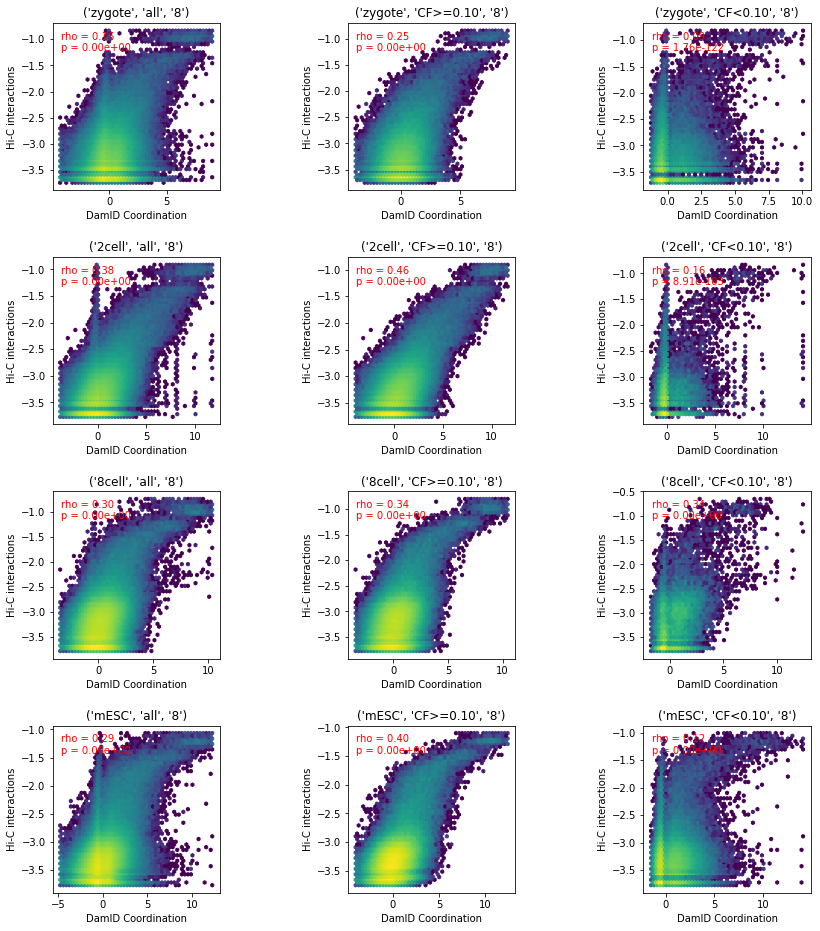

In [103]:
chrom = '8'
allele = 'combined'
ind = ((anno.genotype=='homozygous') | (anno.stage=='mESC')) & (anno.treatment == 'no_treatment')
to_plot_ls = [info for info, _ in anno[ind].groupby(['stage','genotype','treatment'])]
nrow = 4
ncol = 3
max_dist = 200e6
CF_THRESH = 0.1

fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*5, nrow*4))
plt.subplots_adjust(hspace=.4)

for irow, condition in enumerate(to_plot_ls):
    stage = condition[0]
    
    # select matrices
    M1 = np.copy(D_to_plot[allele][condition][chrom])
    M2 = np.copy(Hlog_to_plot[allele][match_stages[stage]][chrom])
    n = M1.shape[0]
    
    M2[np.isinf(M2)] = np.nan

    # generate mask for distances that are too great
    dmax = min(int(max_dist//BINSIZE), n-1)
    print(dmax)
    filt_ind = np.triu_indices(n, dmax)
    
    # remove distances >30Mb
    M2[filt_ind] = np.nan
    M2[M2<=-4]=np.nan
    
    # generate mask for CF values that are too small
    CF = contact_freq[allele][condition][chrom]
    cf_include = CF > CF_THRESH
    
    plot_dict = {
        'all': np.copy(M1),
    }
    tmp = np.copy(M1)
    tmp[~cf_include,:] = np.nan
    tmp[:,~cf_include] = np.nan
    plot_dict['CF>=%.2f'%CF_THRESH] = tmp
    tmp = np.copy(M1)
    tmp[cf_include,:] = np.nan
    tmp[:,cf_include] = np.nan
    plot_dict['CF<%.2f'%CF_THRESH] = tmp
    
    for icol, dataset in enumerate(['all', 'CF>=%.2f'%CF_THRESH, 'CF<%.2f'%CF_THRESH]):
        M1 = plot_dict[dataset]
    
        # plot complete correlation
        ind = np.triu_indices(n,1)
        X = M1[ind]
        Y = M2[ind]
        filt = ~(np.isnan(X) | np.isnan(Y))
        X = X[filt]
        Y = Y[filt]

        ax = axes[irow,icol]
        ax.set_title((stage,dataset,chrom))
        
        yrange = np.percentile(Y, [0.1,99.99])
        xrange = np.percentile(X, [0.1,99.99])
        ax.hexbin(
            X.clip(xrange[0],xrange[1]), Y.clip(yrange[0], yrange[1]), 
            bins='log', gridsize=50, 
            extent=[xrange[0],xrange[1],yrange[0], yrange[1]]
        )

        ax.set_xlabel('DamID Coordination')
        ax.set_ylabel('Hi-C interactions')
        ax.set_box_aspect(1)

        r, p = stats.spearmanr(X, Y)
        t = 'rho = %.2f\np = %.2e' % (r, p)
        ax.text(0.05, 0.95, t, va='top', transform=ax.transAxes, c='r')

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

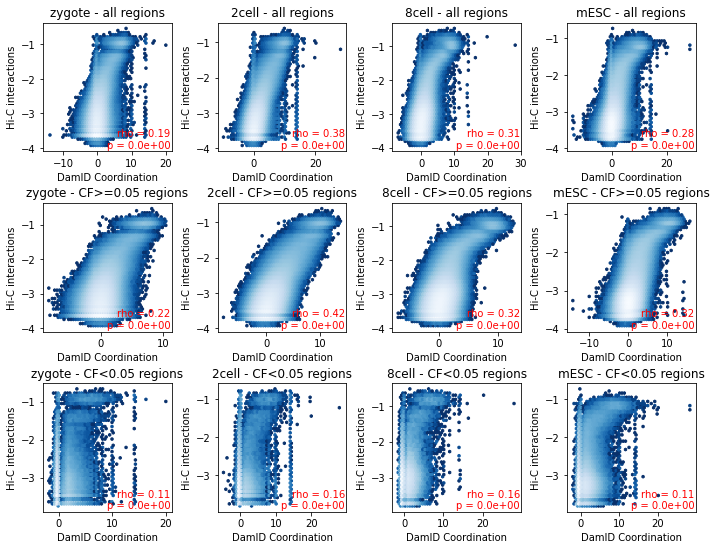

In [105]:
allele = 'combined'
ind = ((anno.genotype=='homozygous') | (anno.stage=='mESC')) & (anno.treatment == 'no_treatment')
to_plot_ls = [info for info, _ in anno[ind].groupby(['stage','genotype','treatment'])]
nrow = 3
ncol = 4
max_dist = 50e6
CF_THRESH = 0.05

fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*3, nrow*3))
plt.subplots_adjust(hspace=.4)

for icol, condition in enumerate(to_plot_ls):
    stage = condition[0]
    
    X_to_plot = defaultdict(list)
    Y_to_plot = defaultdict(list)
    
    for chrom in tqdm(chrom_order[:-2]):

        # select matrices
        M1 = np.copy(D_to_plot[allele][condition][chrom])
        M2 = np.copy(Hlog_to_plot[allele][match_stages[stage]][chrom])
        n = M1.shape[0]

        M2[np.isinf(M2)] = np.nan

        # generate mask for distances that are too great
        dmax = min(int(max_dist//BINSIZE), n-1)
        filt_ind = np.triu_indices(n, dmax)

        # remove distances >30Mb
        M2[filt_ind] = np.nan
        M2[M2==-4] = np.nan

        # generate mask for CF values that are too small
        CF = contact_freq[allele][condition][chrom]
        cf_include = (CF > CF_THRESH)

        plot_dict = {
            'all': np.copy(M1),
        }
        tmp = np.copy(M1)
        tmp[~cf_include,:] = np.nan
        tmp[:,~cf_include] = np.nan
        plot_dict['CF>=%.2f'%CF_THRESH] = tmp
        tmp = np.copy(M1)
        tmp[cf_include,:] = np.nan
        tmp[:,cf_include] = np.nan
        plot_dict['CF<%.2f'%CF_THRESH] = tmp

        for dataset in ['all', 'CF>=%.2f'%CF_THRESH, 'CF<%.2f'%CF_THRESH]:
            M1 = plot_dict[dataset]

            # plot complete correlation
            ind = np.triu_indices(n,1)
            X = M1[ind]
            Y = M2[ind]
            filt = ~(np.isnan(X) | np.isnan(Y))
            X = X[filt]
            Y = Y[filt]
            
            X_to_plot[dataset].append(X)
            Y_to_plot[dataset].append(Y)
            
    for irow, dataset in enumerate(['all', 'CF>=%.2f'%CF_THRESH, 'CF<%.2f'%CF_THRESH]):

        ax = axes[irow,icol]
        ax.set_title('%s - %s regions' % (stage,dataset))
        
        X = np.concatenate(X_to_plot[dataset])
        Y = np.concatenate(Y_to_plot[dataset])

        xlim = [X.min(), X.max()]
        ylim = [Y.min(), Y.max()]
        ax.hexbin(
            X.clip(xlim[0],xlim[1]), Y.clip(ylim[0], ylim[1]), 
            bins='log', gridsize=50, cmap='Blues_r',
            extent=[xlim[0],xlim[1],ylim[0],ylim[1]]
        )

        ax.set_xlabel('DamID Coordination')
        ax.set_ylabel('Hi-C interactions')
        ax.set_box_aspect(1)

        r, p = stats.spearmanr(X, Y)
        t = 'rho = %.2f\np = %.1e' % (r, p)
        ax.text(0.99, 0.01, t, ha='right', va='bottom', transform=ax.transAxes, c='r')

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

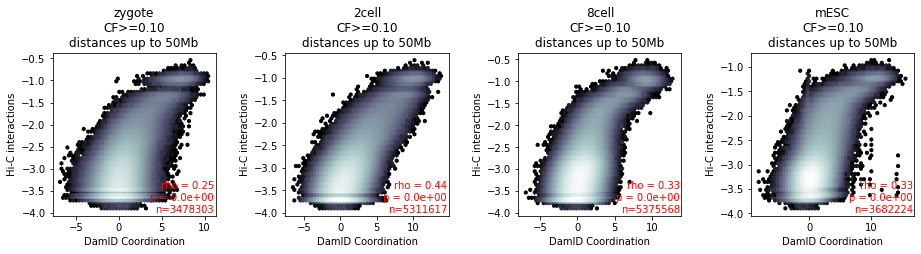

In [36]:
allele = 'combined'
ind = ((anno.genotype=='homozygous') | (anno.stage=='mESC')) & (anno.treatment == 'no_treatment')
to_plot_ls = [info for info, _ in anno[ind].groupby(['stage','genotype','treatment'])]
nrow = 1
ncol = 4
max_dist = 50e6
CF_THRESH = 0.1

fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*3))
plt.subplots_adjust(hspace=.4)

for icol, condition in enumerate(to_plot_ls):
    stage = condition[0]
    
    X_to_plot = list()
    Y_to_plot = list()
    
    for chrom in tqdm(chrom_order[:-2]):

        # select matrices
        M1 = np.copy(D_to_plot[allele][condition][chrom])
        M2 = np.copy(Hlog_to_plot[allele][match_stages[stage]][chrom])
        n = M1.shape[0]

        M2[np.isinf(M2)] = np.nan

        # generate mask for distances that are too great
        dmax = min(int(max_dist//BINSIZE), n-1)
        filt_ind = np.triu_indices(n, dmax)

        # remove distances >30Mb
        M2[filt_ind] = np.nan
        M2[M2<=-3.9] = np.nan

        # generate mask for CF values that are too small
        CF = contact_freq[allele][condition][chrom]
        cf_include = (CF > CF_THRESH)

        # remove regions with CF < thresh
        M1[~cf_include,:] = np.nan
        M1[:,~cf_include] = np.nan

        # flatten data
        ind = np.triu_indices(n,1)
        X = M1[ind]
        Y = M2[ind]
        filt = ~(np.isnan(X) | np.isnan(Y))
        X = X[filt]
        Y = Y[filt]

        X_to_plot.append(X)
        Y_to_plot.append(Y)
            

    ax = axes[icol]
    ax.set_title('%s\nCF>=%.2f\ndistances up to %.0fMb' % (stage,CF_THRESH, max_dist/1e6))

    X = np.concatenate(X_to_plot)
    Y = np.concatenate(Y_to_plot)

    xlim = [X.min(), X.max()]
    ylim = [Y.min(), Y.max()]
    ax.hexbin(
        X.clip(xlim[0],xlim[1]), Y.clip(ylim[0], ylim[1]), 
        bins='log', gridsize=50, cmap='bone',
        extent=[xlim[0],xlim[1],ylim[0],ylim[1]]
    )

    ax.set_xlabel('DamID Coordination')
    ax.set_ylabel('Hi-C interactions')
    ax.set_box_aspect(1)

    r, p = stats.spearmanr(X, Y)
    t = 'rho = %.2f\np = %.1e\nn=%d' % (r, p, len(X))
    ax.text(0.99, 0.01, t, ha='right', va='bottom', transform=ax.transAxes, c='r')
    
outfn = FIGOUTDIR + 'correlation_HiC_interactions_vs_DamID_coordination.pdf'
plt.savefig(outfn, bbox_inches='tight')

## 3.6 Correlation between Hi-C obs/exp and coordination - data of all somatic chromosomes concatenated before correlation computation

In [83]:
smooth_std = 200000
W = gaussian(np.ceil(smooth_std / BINSIZE * 4 / 2) * 2 + 1, smooth_std / BINSIZE)
W /= W.sum()

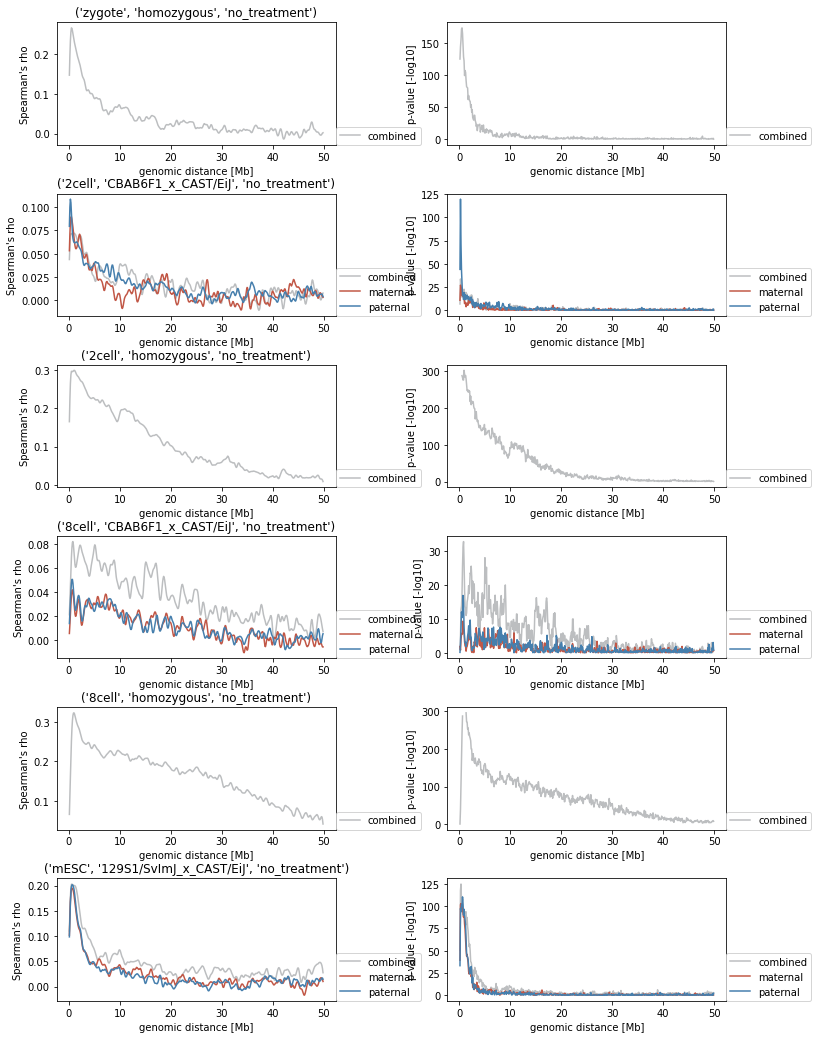

In [86]:
allele = 'combined'
max_dist = 50e6

ind = (anno.treatment == 'no_treatment')
to_plot_ls = [info for info, _ in anno[ind].groupby(['stage','genotype','treatment'])]

nrow = len(to_plot_ls)
ncol = 2
fig, axes = plt.subplots(nrow, 2, figsize=(12, 3*nrow))
plt.subplots_adjust(hspace=.4, wspace=.4)

r_ls_dict = dict()
p_ls_dict = dict()

for irow, condition in enumerate(to_plot_ls):

    ax0 = axes[irow,0]
    ax1 = axes[irow,1]
    
    ax0.set_title(condition)

    stage = condition[0]
    
    
    alleles = ['combined', 'maternal', 'paternal'] if condition[1] in GENOTYPE2PARENT else ['combined']
    for allele in alleles:

        # select and prepare data
        coord_tmp = dict()
        for chrom in chrom_order[:-2]:
            D = np.copy(D_to_plot[allele][condition][chrom])
            cf = contact_freq[allele][condition][chrom]
            D[cf<0.2,:] = np.nan
            D[:,cf<0.2] = np.nan
            coord_tmp[chrom] = D

        # correlation across distance scales
        r_ls = list()
        p_ls = list()

        A = list()
        B = list()

        dmax = int(max_dist//BINSIZE)
        dist_ls = np.arange(1,dmax)

        for dist in dist_ls:
            A_ls = list()
            B_ls = list()

            for chrom in chrom_order[:-2]:
                n = coord_tmp[chrom].shape[0]

                if dist >= n:
                    continue

                ind = select_kth_diag(n, dist)

                A = coord_tmp[chrom][ind]
                B = Hlog_to_plot[allele][match_stages[stage]][chrom][ind]
                filt = ~(np.isnan(A) | np.isnan(B))

                A_ls.append(A[filt])
                B_ls.append(B[filt])

            A_ls = np.concatenate(A_ls)
            B_ls = np.concatenate(B_ls)

            r, p = stats.spearmanr(A_ls, B_ls)
            r_ls.append(r)
            p_ls.append(p)

        p_ls = np.array(p_ls)
        p_ls_log = np.zeros(len(p_ls))
        p_ls_log[p_ls != 0] = -np.log10(p_ls[p_ls!=0])
        p_ls_log[p_ls == 0] = np.nan

        p_ls_dict[(stage, max_dist)] = np.copy(p_ls_log)
        r_ls_dict[(stage, max_dist)] = np.copy(np.array(r_ls))

        X = (dist_ls * BINSIZE) / 1e6

        if max_dist > 30e6:
            r_ls = np.array(r_ls)
            r_ls = fftconvolve(r_ls, W, mode='same')

        ax0.plot(X, r_ls, label=allele, color=color_dict['allele'][allele])
        ax1.plot(X, p_ls_log, label=allele, color=color_dict['allele'][allele])


    ax0.set_ylabel('Spearman\'s rho')
    ax0.set_xlabel('genomic distance [Mb]')
    ax0.legend(loc=(1,0))

    ax1.set_ylabel('p-value [-log10]')
    ax1.set_xlabel('genomic distance [Mb]')
    ax1.legend(loc=(1,0))


# 6. Average coordination in LADs

## 6.1 Function to compute average signal within regions

In [37]:
def rescale_tads_shifts(
    M, BINSIZE, feat, 
    pad=1, rescale_size=99, 
    shiftNorm=True, minShift=3e5, maxShift=2e6, nShifts=10, norm_method='fc',
    seed=42):
    """
    Rescale TADs to pile-up based on coolpup.py
    
    Parameters
    ----------
    M : dict
        {chrom : 2d array}. 2d array is chromosome Hi-C matrix.
    BINSIZE : int, float
          matrix binsize. 
    feat : df
           genomic features in dataframe with ['chrom', 'start', 'end'] columns
    rescale_size : int
                   number of rescaled pixels.
    shiftNorm : bool
                whether or not the average signal should be normalized for signal of shifted regions.
    minShift : int, float
               minimum random shift distance from on-target feature. 
    maxShift : int, float
               maximum random shift distance from on-target feature.
    nShifts : int
              number of random shifts.
    norm_method: str (options: fc, diff)
                 method by which signal is normalized for shifted signal: fold-change (fc) or difference (diff)
    seed : int
           random seed used for random shifts. 
             
    Returns
    -------
    out : 2d array
          rescaled pile-up profile. 
    """
    from cooltools import numutils
    
    if shiftNorm:
        assert norm_method in ['fc', 'diff']
    
    # evaluate and format feature DF
    assert feat.shape[1] >= 3, 'Invalid feature DF'
    feat = feat.iloc[:,:3].copy()
    feat.columns = ['chrom', 'start', 'end']
    
    
    minShift = int(minShift/BINSIZE)
    maxShift = int(maxShift/BINSIZE)
    
    np.random.seed(seed)
    
    profile = np.zeros((rescale_size, rescale_size))
    profileShifts = np.zeros((rescale_size, rescale_size))
    
    n = 0
    for chrom, feat_chrom in feat.groupby('chrom'):
        
        Mchr = np.copy(M[chrom])
        Mchr[np.isnan(Mchr)] = 0
        
        if np.isinf(Mchr).sum() > 0:
            v = np.percentile(Mchr[~np.isinf(Mchr)], [1,99])
            Mchr[Mchr==-np.inf] = v[0]
            Mchr[Mchr==np.inf] = v[1]
        
        for _, row in feat_chrom.iterrows():
            
            s = int(np.round(row['start']//BINSIZE,0))
            e = int(np.round(row['end']//BINSIZE,0))
            size = abs(s - e)
            w = int(size * pad)
            
            if ((s-w) < 0) or ((e+w)>len(Mchr)):
                continue
            p = Mchr[(s - w):(e + w), (s - w):(e + w)]
            rescale = numutils.zoom_array(p, (rescale_size, rescale_size))
            assert np.isnan(rescale).sum()==0

            profile += rescale

            #random shifts
            if shiftNorm:
                u = np.random.randint((s - maxShift), (s - minShift), nShifts*5) #upstream shifts
                d = np.random.randint((e + minShift), (e + maxShift), nShifts*5) #downstream shifts
                shifts = np.concatenate((u, d))
                shifts = shifts[((shifts - w) > 0) & ((shifts + size + w) < len(Mchr))] # select shifts that fall on chromosome
                
                shifts = np.random.choice(shifts, nShifts, replace=False).astype(int)

                for shift in shifts:
                    pShift = Mchr[(shift - w):(shift + size + w), (shift - w):(shift + size + w)] #shift is considered start of TAD
                    rescaleShift = numutils.zoom_array(pShift, (rescale_size, rescale_size))
                    profileShifts += rescaleShift              

            n += 1
            
    print(f"Total number of piled up windows: {n}")
        
    assert np.isnan(profile).sum() == 0
    
    profile /= n
    if shiftNorm:
        assert np.isnan(profileShifts).sum() == 0
        profileShifts /= (n * nShifts)
        
        if norm_method == 'fc':
            profile = profile / profileShifts
        elif norm_method == 'diff':
            profile = profile - profileShifts
    
    return (n, profile)

# Determining CF in PADs

In [38]:
pad_ind_select = dict()

for irow, row in pads_merged.iterrows():

    si = (row['start'] // BINSIZE)
    ei = int(np.ceil(row['end']/BINSIZE))
    n = (ei - si)

    assert si != ei, row
    
    if n==1:
        weights = [1]
    else:
        fs = ((si+1)*BINSIZE - row['start'])/BINSIZE
        fe = (row['end'] - (ei-1)*BINSIZE)/BINSIZE
        weights = [fs] + [1]*(n-2) + [fe]
        
    ind = np.arange(si,ei)
    weights = np.array(weights)
    pad_ind_select[irow] = (ind, weights)

In [39]:
pad_cf_values = dict()

for allele in contact_freq:
    pad_cf_values[allele] = dict()
    for sample in contact_freq[allele]:
        cf = contact_freq[allele][sample]
        
        tmp = list()
        for irow, row in pads_merged.iterrows():
            ind, w = pad_ind_select[irow]
            v = (cf[row['chrom']][ind]*w).sum() / w.sum()
            tmp.append(v)
            
        pad_cf_values[allele][sample] = np.array(tmp)

In [40]:
anno.genotype.unique()

array(['homozygous', '129S1/SvImJ_x_CAST/EiJ', 'CBAB6F1_x_CAST/EiJ',
       'C57BL/6J_x_JF1/Ms'], dtype=object)

<Axes: xlabel='cf', ylabel='Count'>

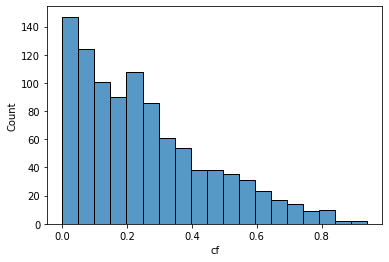

In [41]:
allele = 'maternal'
condition = ('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment')


df = pads_merged.copy()
df['cf'] = pad_cf_values[allele][condition]
ind = (~df.chrom.isin(['X','Y'])) & ((df['end']-df['start'])>3e5)
df = df[ind]

sns.histplot(df['cf'], binwidth=0.05)

# 7. Average coordination between LADs

## 7.1 Function to compute average signal within regions

In [48]:
from collections import defaultdict, Counter

In [49]:
from itertools import combinations

In [50]:
def rescale_intertads_shifts(
    M, BINSIZE, feat, 
    pad=1, rescale_size=99, 
    separate_by_distance=False, min_dist=0, max_dist=np.inf, distance_category_size=10e6, distance_categories=[],
    shiftNorm=True, minShift=3e5, maxShift=2e6, nShifts=10, norm_method='fc',
    seed=42):
    """
    Rescale TADs to pile-up based on coolpup.py
    
    Parameters
    ----------
    M : dict
        {chrom : 2d array}. 2d array is chromosome Hi-C matrix.
    BINSIZE : int, float
          matrix binsize. 
    feat : df
           genomic features in dataframe with ['chrom', 'start', 'end'] columns; 
           inter-feature signal will be computed for regions on the same chromosome.
    rescale_size : int
                   number of rescaled pixels.
    separate_by_distance : bool
                           whether or not to make separate average profiles based on the inter-feature distance.
    distance_category_size : int
                             the size of the different distance categories if separate_by_dsitance==True
    shiftNorm : bool
                whether or not the average signal should be normalized for signal of shifted regions.
    minShift : int, float
               minimum random shift distance from on-target feature. 
    maxShift : int, float
               maximum random shift distance from on-target feature.
    nShifts : int
              number of random shifts.
    norm_method: str (options: fc, diff)
                 method by which signal is normalized for shifted signal: fold-change (fc) or difference (diff)
    seed : int
           random seed used for random shifts. 
             
             
    Returns
    -------
    out : 2d array
          rescaled pile-up profile. 
    """
    from cooltools import numutils
    
    if shiftNorm:
        assert norm_method in ['fc', 'diff']
        

    
    # evaluate and format feature DF
    assert feat.shape[1] >= 3, 'Invalid feature DF'
    feat = feat.iloc[:,:3].copy()
    feat.columns = ['chrom', 'start', 'end']
    
    minShift = int(minShift/BINSIZE)
    maxShift = int(maxShift/BINSIZE)
    
    np.random.seed(seed)
    
    profile_template = np.zeros((rescale_size, rescale_size))
    
    if separate_by_distance:
        profile = defaultdict(lambda: np.copy(profile_template))
        profileShifts = defaultdict(lambda: np.copy(profile_template))
        
        
        if len(distance_categories) == 0:
            distance_categories = np.arange(0, int(250e6), int(distance_category_size))
        else:
            distance_categories = np.array(distance_categories)

        n = dict()
        
    else:
        profile = np.copy(profile_template)
        profileShifts = np.copy(profile_template)
        n = np.copy(profile_template)
        
    # iterate over chromosomes
    for chrom, feat_chrom in feat.groupby('chrom'):
        
        # select chromosome matrix
        Mchr = np.copy(M[chrom])
        
        # mask regions that close to the diagnonal (3 bins)
        for k in range(3):
            ind = select_kth_diag(Mchr.shape[0],k)
            Mchr[ind] = np.nan
            if k > 0:
                ind = select_kth_diag(Mchr.shape[0],-k)
                Mchr[ind] = np.nan
        Mchr_isvalid = (~np.isnan(Mchr)) & (~np.isinf(Mchr)).astype(int)
        Mchr[np.isnan(Mchr)] = 0
        
        if np.isinf(Mchr).sum() > 0:
#             Mchr[np.isinf] = 0
            v = np.percentile(Mchr[~np.isinf(Mchr)], [1,99])
            Mchr[Mchr==-np.inf] = v[0]
            Mchr[Mchr==np.inf] = v[1]
            
        # select all pairwise combinations
        feat_chrom = feat_chrom.copy().reset_index(drop=True)
        region_combinations = combinations(feat_chrom.index.values, 2)
        
        # iterate over feature pairs
        for i, j in region_combinations:
            
            # assert i is the downstream region and j is the upstream region
            if feat_chrom.loc[i,'start'] > feat_chrom.loc[j,'start']:
                tmp = i
                i = j
                j = tmp
                
            # determine whether the minimum distance is met
            inter_domain_dist = (feat_chrom.loc[j,'start']-feat_chrom.loc[i,'end'])
            if (inter_domain_dist < min_dist) or (inter_domain_dist >= max_dist):
                continue
                
            # determine in which distance category this pair falls
            
            if inter_domain_dist > distance_categories[-1]:
                tmp = 300e6 if np.isinf(max_dist) else max_dist
                dist_category = '%d-%d' % (distance_categories[-1], max_dist)
            elif inter_domain_dist < distance_categories[0]:
                dist_category = '%d-%d' % (int(min_dist),int(distance_categories[0]))
            else:
                ci = np.arange(len(distance_categories))[distance_categories>inter_domain_dist][0]
                dist_category = '%d-%d' % (distance_categories[ci-1], distance_categories[ci])
            
            # define region indices for region i
            start_i = feat_chrom.loc[i,'start']
            end_i = feat_chrom.loc[i,'end']
            s_i = int(np.round(start_i//BINSIZE,0))
            e_i = int(np.round(end_i//BINSIZE,0))
            size_i = abs(s_i - e_i)
            w_i = int(size_i * pad)
            
            if ((s_i-w_i) < 0) or ((e_i+w_i)>len(Mchr)):
                continue
                
            # define region indices for region j
            start_j = feat_chrom.loc[j,'start']
            end_j = feat_chrom.loc[j,'end']
            s_j = int(np.round(start_j//BINSIZE,0))
            e_j = int(np.round(end_j//BINSIZE,0))
            size_j = abs(s_j - e_j)
            w_j = int(size_j * pad)
            
            if ((s_j-w_j) < 0) or ((e_j+w_j)>len(Mchr)):
                continue

            # select data in matrix
            p = Mchr[(s_i - w_i):(e_i + w_i), (s_j - w_j):(e_j + w_j)]
            rescale = numutils.zoom_array(p, (rescale_size, rescale_size))
            p_isvalid = Mchr_isvalid[(s_i - w_i):(e_i + w_i), (s_j - w_j):(e_j + w_j)]
            rescale_isvalid = numutils.zoom_array(p_isvalid, (rescale_size, rescale_size)) > 0.8
            assert np.isnan(rescale).sum()==0

            
            # perform random shifts if requested
            if shiftNorm:
                
                # generate random shifts
                u = np.random.randint(-maxShift, -minShift, nShifts*5) #upstream shifts
                d = np.random.randint(minShift, maxShift, nShifts*5) #downstream shifts
                shifts = np.concatenate((u, d))
                
                # filter out random shifts that "walk" outside of the chromosome
                ind_i = ((s_i - w_i + shifts) > 0) & ((e_i + w_i + shifts) < len(Mchr))
                ind_j = ((s_j - w_j + shifts) > 0) & ((e_j + w_j + shifts) < len(Mchr))
                shifts = shifts[ind_i & ind_j]
#                 shifts = shifts[((shifts - w) > 0) & ((shifts + size + w) < len(Mchr))] # select shifts that fall on chromosome
                
                if len(shifts) < nShifts:
                    continue
                
                shifts = np.random.choice(shifts, nShifts, replace=False).astype(int)

                for shift in shifts:
                    pShift = Mchr[(s_i - w_i + shift):(e_i + w_i + shift), (s_j - w_j + shift):(e_j + w_j + shift)] #shift is considered start of TAD
                    rescaleShift = numutils.zoom_array(pShift, (rescale_size, rescale_size))
                    
#                     pShift_isvalid = Mchr_isvalid[(s_i - w_i + shift):(e_i + w_i + shift), (s_j - w_j + shift):(e_j + w_j + shift)]
#                     rescaleShift_isvalid = numutils.zoom_array(pShift_isvalid, (rescale_size, rescale_size))
                    
                    if separate_by_distance:
                        profileShifts[dist_category] += rescaleShift
                    else:
                        profileShifts += rescaleShift
                    
            if separate_by_distance:
                profile[dist_category] += rescale
                if dist_category in n:
                    n[dist_category] = n[dist_category] + (rescale_isvalid).astype(int)
                else:
                    n[dist_category] = (rescale_isvalid).astype(int)
            else:
                profile += rescale
                n = n + (rescale_isvalid).astype(int)
            
    if separate_by_distance:
        print("Total number of piled up windows: ", {d: np.max(n[d]) for d in n.keys()})
    else:
        print("Total number of piled up windows: ", max(n))
        
    
    
    if separate_by_distance:
        
        for dist_category in n:
            assert np.isnan(profile[dist_category]).sum() == 0
            profile[dist_category] /= n[dist_category]
            
            if shiftNorm:
                assert np.isnan(profileShifts[dist_category]).sum() == 0
                profileShifts[dist_category] /= (n[dist_category] * nShifts)
                
                if norm_method == 'fc':
                    profile[dist_category] = profile[dist_category] / profileShifts[dist_category]
                elif norm_method == 'diff':
                    profile[dist_category] = profile[dist_category] - profileShifts[dist_category]
            
    else:
        assert np.isnan(profile).sum() == 0
        profile /= n
        if shiftNorm:
            assert np.isnan(profileShifts).sum() == 0
            profileShifts /= (n * nShifts)
            
            if norm_method == 'fc':
                profile = profile / profileShifts
            elif norm_method == 'diff':
                profile = profile - profileShifts
    
    return (n, profile)

# 8. Coordination within and between PADs

## 8.1 Average coordination per stage in PADs - zscore

In [222]:
avg_coord_in_PADs = dict()

df = pads_merged[~pads_merged.chrom.isin(['X','Y'])].copy()
ind = (df.end-df.start) >= 3e5
print(ind.mean(), ind.sum())
df = df.loc[ind, ['chrom', 'start', 'end']]

for allele in ['maternal', 'paternal', 'combined']:
    avg_coord_in_PADs[allele] = dict()
    
    for condition in coord_matrices['zscore'][allele]:

        M = coord_matrices['zscore'][allele][condition]

        n, C = rescale_tads_shifts(
            M, BINSIZE, df, 
            rescale_size=99, pad=0.5,
            shiftNorm=False, minShift=3e5, maxShift=2e6, nShifts=10, norm_method='diff',
            seed=42
        )

        avg_coord_in_PADs[allele][condition] = (n, C)

0.5182957393483709 1034
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
T

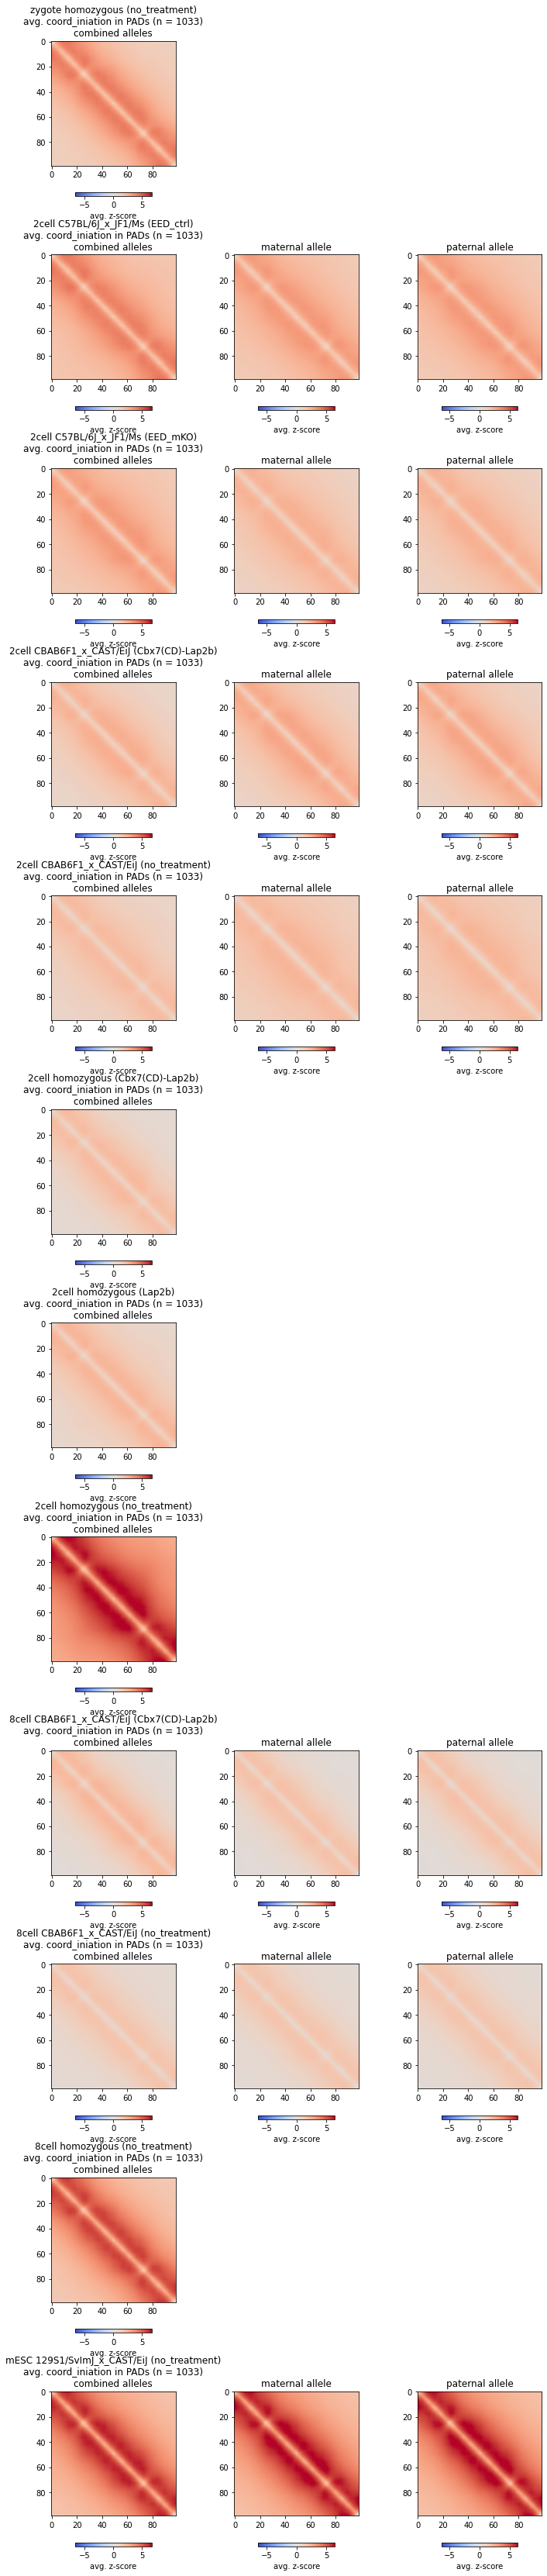

In [223]:
nrow = len(condition_ls)
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(4*ncol, 5*nrow))

for icol, allele in enumerate(['combined','maternal','paternal']):

    vmax = list()
    vmin = list()
    for stage in avg_coord_in_PADs[allele].keys():
        n, C = avg_coord_in_PADs[allele][stage]
        if np.isnan(C).sum() == 0:
            vmin.append(np.percentile(C,2))
            vmax.append(np.percentile(C, 98))
    vmax = max(vmax)
    vmin = min(vmin)

    for irow, condition in enumerate(condition_ls):

        ax = axes[irow,icol]
        if condition not in avg_coord_in_PADs[allele]:
            ax.remove()
            continue
        
        n, C = avg_coord_in_PADs[allele][condition]

        p = ax.imshow(C, cmap='coolwarm', vmin=-vmax, vmax=vmax)
        cbar = plt.colorbar(p, ax=ax, shrink=.5, orientation='horizontal')
        cbar.ax.set_xlabel('avg. z-score')

        if allele == 'combined':
            t = '%s %s (%s)\navg. coord_iniation in PADs (n = %d)\ncombined alleles' % (condition[0], condition[1], condition[2], n)
        else:
            t = '%s allele' % (allele)
        
        ax.set_title(t)

## 8.1 Average coordination per stage in PADs - zscore distnorm

In [220]:
avg_distnorm_coord_in_PADs = dict()

df = pads_merged[~pads_merged.chrom.isin(['X','Y'])].copy()
ind = (df.end-df.start) >= 3e5
print(ind.mean(), ind.sum())
df = df.loc[ind, ['chrom', 'start', 'end']]

for allele in ['maternal', 'paternal', 'combined']:
    avg_distnorm_coord_in_PADs[allele] = dict()
    
    for condition in coord_matrices['zscore_distnorm'][allele]:

        M = coord_matrices['zscore_distnorm'][allele][condition]

        n, C = rescale_tads_shifts(
            M, BINSIZE, df, 
            rescale_size=99, pad=0.5,
            shiftNorm=False, minShift=3e5, maxShift=2e6, nShifts=10, norm_method='diff',
            seed=42
        )

        avg_distnorm_coord_in_PADs[allele][condition] = (n, C)

0.5182957393483709 1034
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
Total number of piled up windows: 1033
T

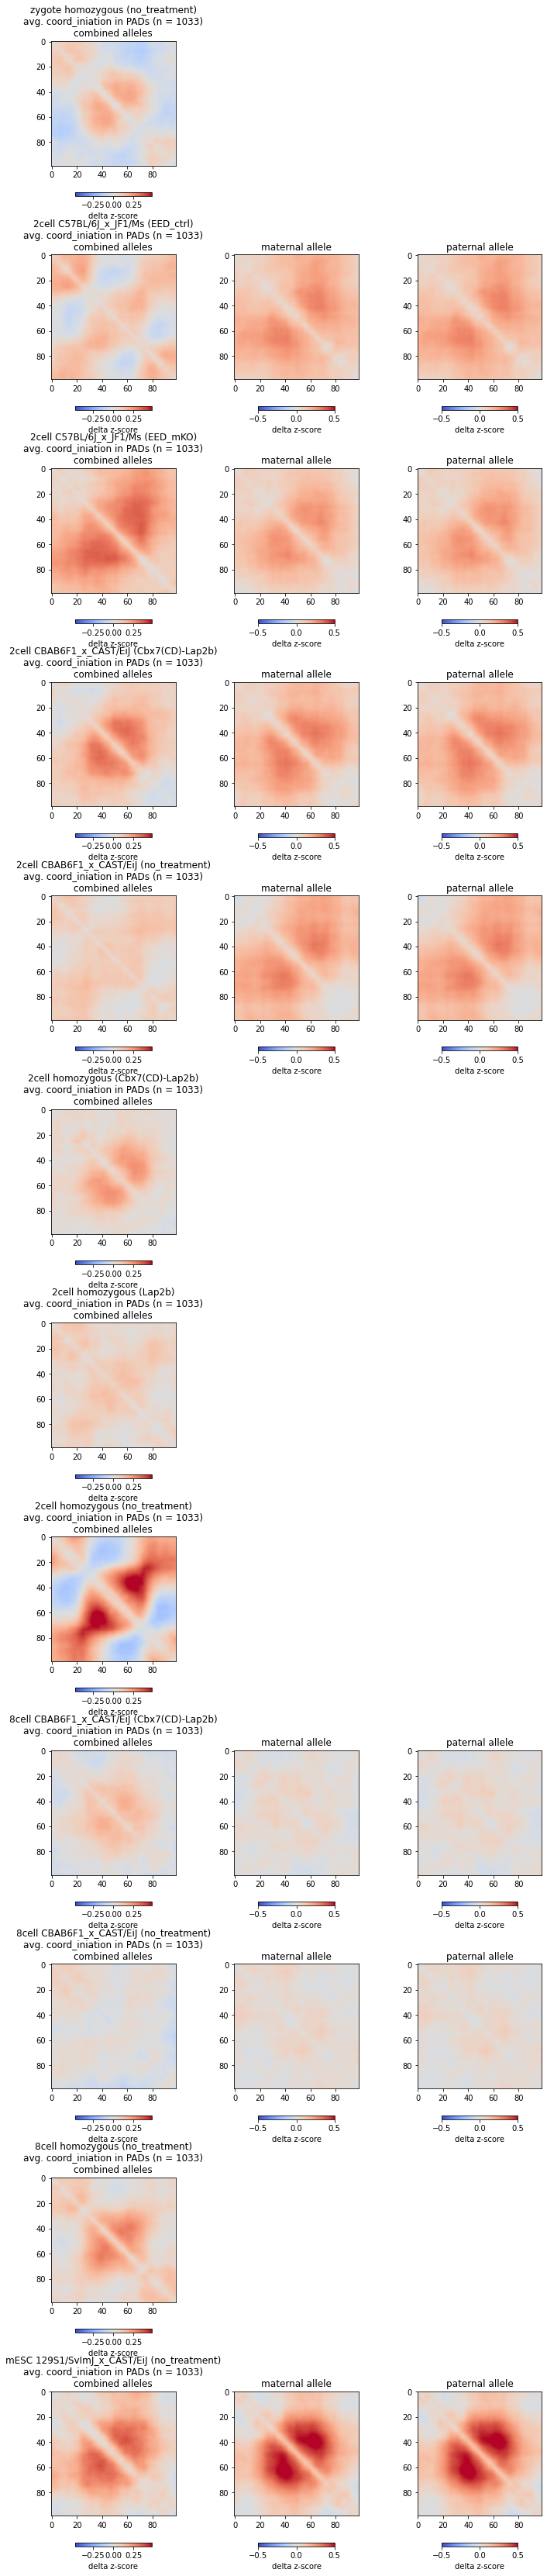

In [221]:
nrow = len(condition_ls)
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(4*ncol, 5*nrow))

for icol, allele in enumerate(['combined','maternal','paternal']):

    vmax = list()
    vmin = list()
    for stage in avg_distnorm_coord_in_PADs[allele].keys():
        n, C = avg_distnorm_coord_in_PADs[allele][stage]
        if np.isnan(C).sum() == 0:
            vmin.append(np.percentile(C,2))
            vmax.append(np.percentile(C, 98))
    vmax = max(vmax)
    vmin = min(vmin)

    for irow, condition in enumerate(condition_ls):

        ax = axes[irow,icol]
        if condition not in avg_distnorm_coord_in_PADs[allele]:
            ax.remove()
            continue
        
        n, C = avg_distnorm_coord_in_PADs[allele][condition]

        p = ax.imshow(C, cmap='coolwarm', vmin=-vmax, vmax=vmax)
        cbar = plt.colorbar(p, ax=ax, shrink=.5, orientation='horizontal')
        cbar.ax.set_xlabel('delta z-score')

        if allele == 'combined':
            t = '%s %s (%s)\navg. coord_iniation in PADs (n = %d)\ncombined alleles' % (condition[0], condition[1], condition[2], n)
        else:
            t = '%s allele' % (allele)
        
        ax.set_title(t)

## 8.2 Average coordination per stage in PADs - with "shift normalization"

In [124]:
# avg_coord_in_PADs_shift = dict()

# df = pads[~pads.chrom.isin(['X','Y'])].copy()
# df = df.loc[(df.end-df.start) >= 3e5, ['chrom', 'start', 'end']]

# for condition in condition_ls:
        
#     M = coord_matrices['zscore'][condition]

#     n, C = rescale_tads_shifts(
#         M, BINSIZE, df, 
#         rescale_size=99, pad=0.5,
#         shiftNorm=True, minShift=3e5, maxShift=2e6, nShifts=10, norm_method='diff',
#         seed=42
#     )

#     avg_coord_in_PADs_shift[condition] = (n, C)

## 8.3 Average coordination per stage between PADs divided by their separation - no "shift normalization"

In [117]:
from collections import Counter

In [45]:
avg_coord_between_PADs = dict()

In [51]:
df = pads_merged[~pads_merged.chrom.isin(['X','Y'])].copy()
df = df.loc[(df.end-df.start) >= 3e5, ['chrom', 'start', 'end']]

to_compute = {'zscore 0-10Mb': [0,10e6], 'zscore 0-20Mb': [0,20e6]}

for name, dist_cats in to_compute.items():
    name2 = name + ' shift-norm'
    avg_coord_between_PADs[name] = dict()
    avg_coord_between_PADs[name2] = dict()
    
    for allele in ['combined','maternal','paternal']:
        avg_coord_between_PADs[name][allele] = dict()
        avg_coord_between_PADs[name2][allele] = dict()

        for condition in coord_matrices['zscore'][allele]:
            print(condition,allele)

            # select coordination matrix
            M = coord_matrices['zscore'][allele][condition]

            # compute interactions WITHOUT shift normalization
            n, C = rescale_intertads_shifts(
                M, BINSIZE, df, 
                pad=1, rescale_size=99, min_dist=dist_cats[0], max_dist=dist_cats[-1],
                separate_by_distance=True, distance_category_size=10e6, distance_categories=dist_cats,
                shiftNorm=False, minShift=3e5, maxShift=2e6, nShifts=10, norm_method='diff',
                seed=42
            )
            avg_coord_between_PADs[name][allele][condition] = (n, C)
            
            # compute interactions WITH shift normalization
            n, C = rescale_intertads_shifts(
                M, BINSIZE, df, 
                pad=1, rescale_size=99, min_dist=dist_cats[0], max_dist=dist_cats[-1], 
                separate_by_distance=True, distance_category_size=10e6, distance_categories=dist_cats,
                shiftNorm=True, minShift=3e5, maxShift=2e6, nShifts=10, norm_method='diff',
                seed=42
            )
            avg_coord_between_PADs[name2][allele][condition] = (n, C)


('zygote', 'homozygous', 'no_treatment') combined
Total number of piled up windows:  {'0-10000000': 5123}
Total number of piled up windows:  {'0-10000000': 5123}
('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') combined
Total number of piled up windows:  {'0-10000000': 5123}
Total number of piled up windows:  {'0-10000000': 5123}
('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO') combined
Total number of piled up windows:  {'0-10000000': 5123}
Total number of piled up windows:  {'0-10000000': 5123}
('2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b') combined
Total number of piled up windows:  {'0-10000000': 5123}
Total number of piled up windows:  {'0-10000000': 5123}
('2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') combined
Total number of piled up windows:  {'0-10000000': 5123}
Total number of piled up windows:  {'0-10000000': 5123}
('2cell', 'homozygous', 'Cbx7(CD)-Lap2b') combined
Total number of piled up windows:  {'0-10000000': 5123}
Total number of piled up windows:  {'0-10000000': 5123}
('2cell'

Total number of piled up windows:  {'0-20000000': 9571}
Total number of piled up windows:  {'0-20000000': 9571}
('8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment') paternal
Total number of piled up windows:  {'0-20000000': 9571}
Total number of piled up windows:  {'0-20000000': 9571}
('mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment') paternal
Total number of piled up windows:  {'0-20000000': 9571}
Total number of piled up windows:  {'0-20000000': 9571}


In [123]:
def plot_interactions_across_distances(datadict, allele, cbarlab='avg. zscore', vmax=0):

    to_plot_ls = list(datadict[allele].keys())
    nrow = len(to_plot_ls)
    dist_cats = list(datadict[allele][to_plot_ls[0]][1].keys())
    dist_cats = sorted(dist_cats, key=lambda k: int(k.split('-')[0].strip('+')))

    ncol = len(dist_cats) + 1
    wr = [1] * len(dist_cats) + [.2]
    fig, axes = plt.subplots(nrow, ncol, figsize=(2*(ncol-1)+0.4, 2*nrow), gridspec_kw={'width_ratios': wr})
    plt.subplots_adjust(wspace=.1, hspace=.1)

    compute_vmax = (vmax == 0)

    for irow, condition in enumerate(to_plot_ls):

        n, C = datadict[allele][condition]
        
        
        if compute_vmax:
            vmax = list()
            for dist in dist_cats:
                if dist in C:
                    vmax.append(np.percentile(C[dist], 98))
            vmax = max(vmax)

        for icol, dist in enumerate(dist_cats):

            ax = axes[irow, icol]

            p = ax.imshow(C[dist], cmap='coolwarm', vmin=-vmax, vmax=vmax)
            if icol == 0:
                cbar = plt.colorbar(p, cax=axes[irow,-1], orientation='vertical')
                cbar.ax.set_ylabel(cbarlab)

            e = int(C[dist].shape[0]/3)
            m = np.median(C[dist][e:2*e,e:2*e])
            ax.text(.5, .5, '%.2f' % m, ha='center', va='center', transform=ax.transAxes)

            dist_a = '%.1f' % (int(dist.split('-')[0].strip('+'))/1e6)
            dist_b = '-%.1fMb' % (int(dist.split('-')[1])/1e6) if '-' in dist else 'Mb+'
            dist_label = dist_a + dist_b
            if icol == 0:
                t = '%s %s\n(%s)\n%s (n = %d)' % (condition[0], condition[2], condition[1], dist_label, np.max(n[dist]))
            else:
                t = '%s (n = %d)' % (dist_label, np.max(n[dist]))
            ax.text(0.05, 0.95, t, ha='left', va='top', transform=ax.transAxes, fontsize=8)

            ax.set_xticks([])
            ax.set_yticks([])

            if icol == 0:
                ax.set_ylabel('upstream PAD')
            if irow == (nrow-1):
                ax.set_xlabel('downstream PAD')

In [112]:
avg_coord_between_PADs.keys()

dict_keys(['zscore 0-10Mb', 'zscore 0-10Mb shift-norm', 'zscore 0-20Mb', 'zscore 0-20Mb shift-norm'])

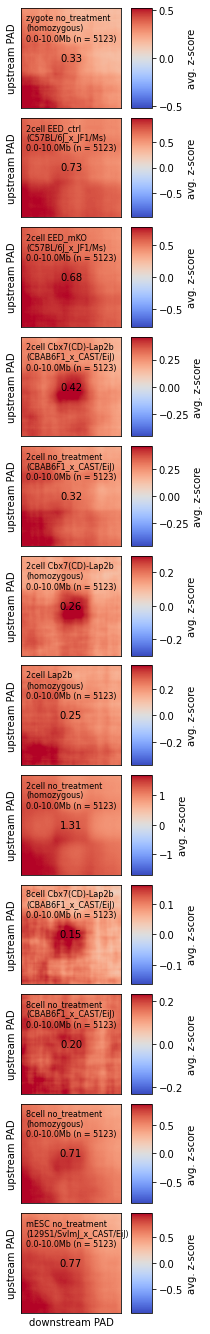

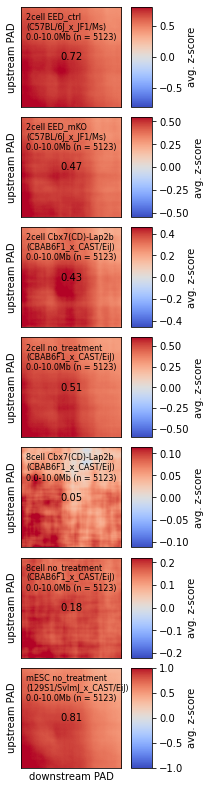

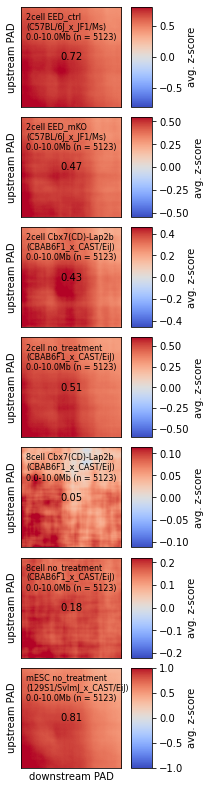

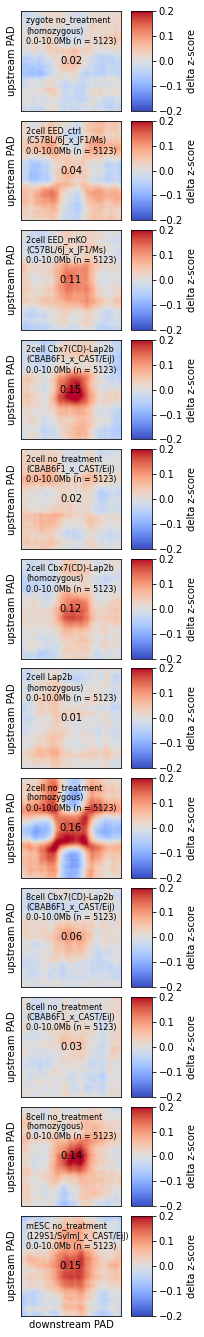

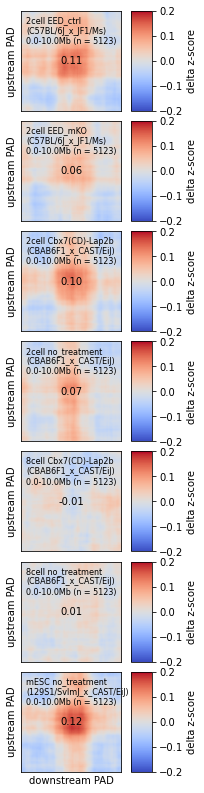

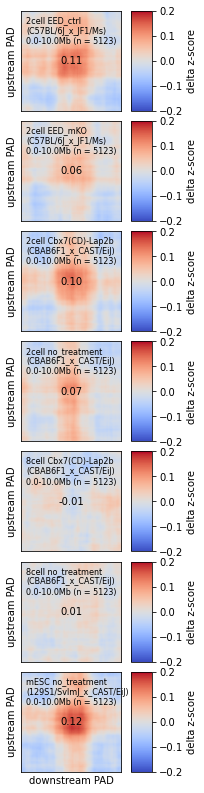

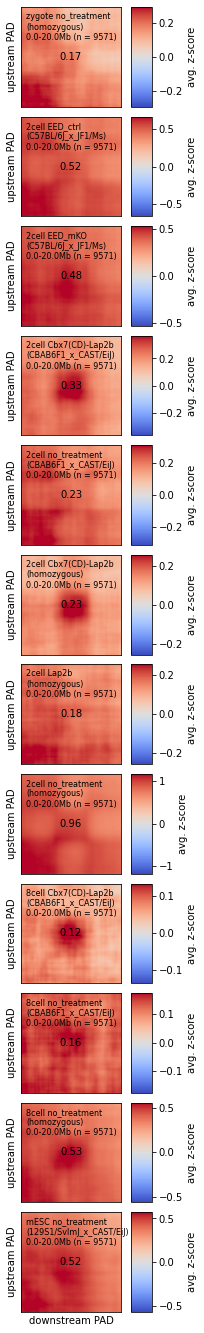

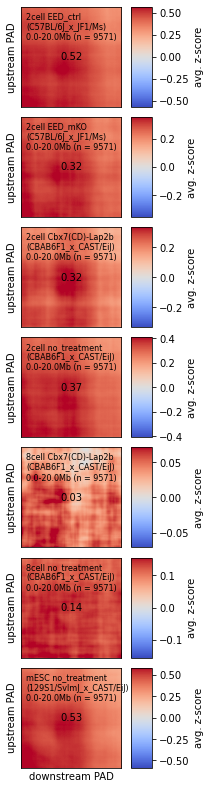

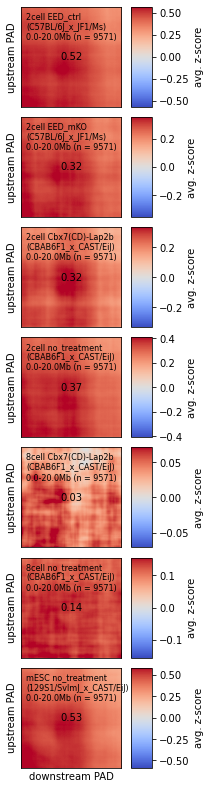

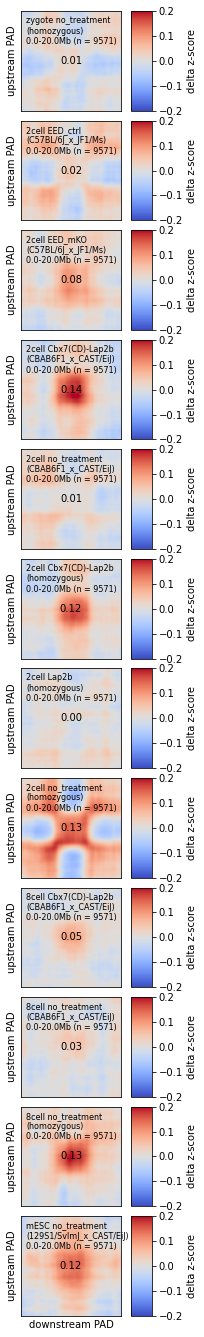

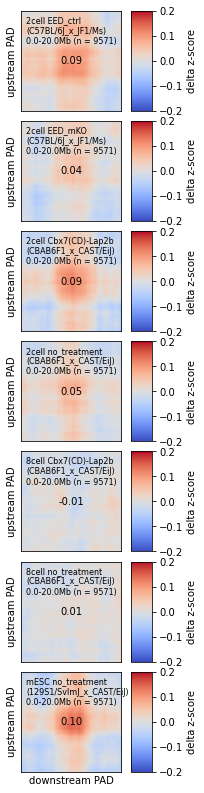

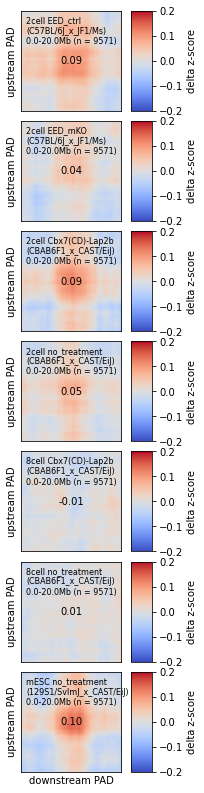

In [126]:
for name in avg_coord_between_PADs:
    for allele in ['combined', 'maternal', 'paternal']:
        
        lab = 'delta z-score' if 'shift' in name else 'avg. z-score'
        vmax = 0.2 if 'shift' in name else 0
        
        plot_interactions_across_distances(
            avg_coord_between_PADs[name], allele, cbarlab=lab, vmax=vmax
        )
        
        dist = '20Mb' if '20Mb' in name else '10Mb'
        metric = 'DamID_zscore_shiftnorm' if 'shift' in name else 'DamID_zscore'
        outfn = FIGOUTDIR + 'PAD_coordination_up_to_%s.%s.%s_allele.pdf' % (dist, metric, allele)
        plt.savefig(outfn, bbox_inches='tight')

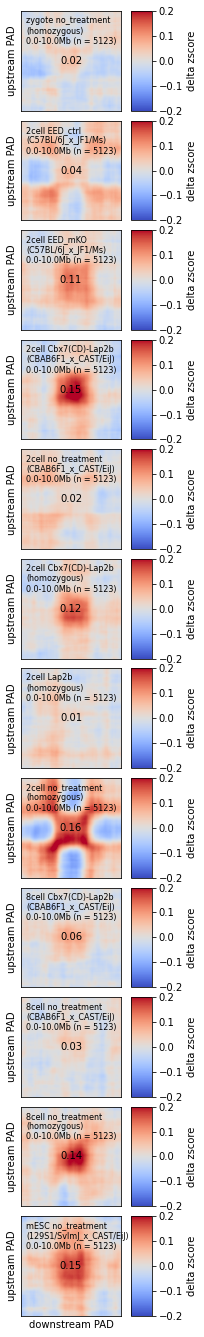

In [125]:
plot_interactions_across_distances(
    avg_coord_between_PADs['zscore 0-10Mb shift-norm'], 'combined', cbarlab='delta zscore', vmax=0.2
)

# 9. Saddle plots

## 9.1 Hi-C saddle plots of compartments

In [143]:
results= dict()

for stage in stage_order:
    
    # select data
    sample = match_stages[stage]
    clr = hic_matrices[sample]
    cvd = hic_exp_cis[sample].copy()

    Q_LO = 0.025 # ignore 2.5% of genomic bins with the lowest E1 values
    Q_HI = 0.975 # ignore 2.5% of genomic bins with the highest E1 values
    N_GROUPS = 38 # divide remaining 95% of the genome into 38 equisized groups, 2.5% each

    ev = compartments[['chrom', 'start', 'end', sample]].copy()
    ev = ev[~ev.chrom.isin(['X', 'Y'])]

    view_df = pd.DataFrame({'chrom': clr.chromnames,
                        'start': 0,
                        'end': clr.chromsizes.values,
                        'name': clr.chromnames}
                      )
    view_df = view_df[~view_df.chrom.isin(['X', 'Y'])]
    
    interaction_sum, interaction_count =  cooltools.saddle(
            clr,
            cvd,
            ev,
            'cis',
            n_bins=N_GROUPS,
            qrange=(Q_LO,Q_HI),
            view_df=view_df
    )
    
    results[sample] = interaction_sum / interaction_count

In [144]:
from matplotlib.colors import Normalize, LogNorm

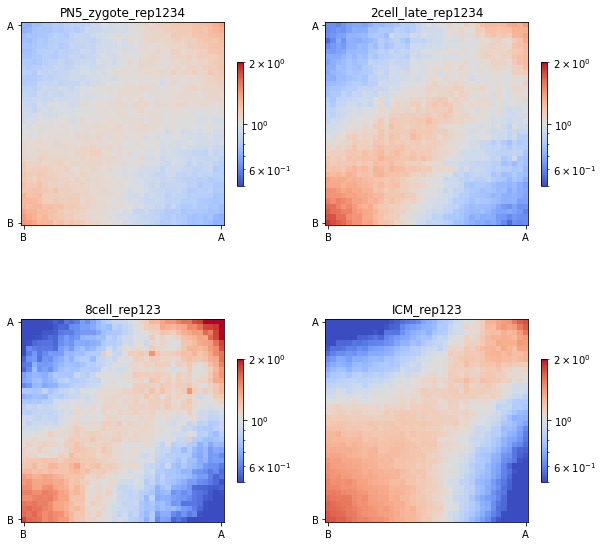

In [145]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

for iplot, stage in enumerate(stage_order):
    sample = match_stages[stage]
    M = np.copy(results[sample])[1:-1, 1:-1]
    
    ax = axes.flatten()[iplot]
    ax.set_title(sample)
    
    p = ax.imshow(M, cmap='coolwarm', norm=LogNorm(vmin=.5, vmax=2), origin='lower')
    plt.colorbar(p, shrink=0.5, ax=ax)
    
    ax.set_xticks([0, M.shape[0]-1])
    ax.set_yticks([0, M.shape[0]-1])
    ax.set_xticklabels(['B', 'A'])
    ax.set_yticklabels(['B', 'A'])

## 9.2 Function to make coordination saddle plot

In [152]:
def summarize_data_to_saddle(n_bins, min_diag_dist=3, divide_by_CF=False):

    if divide_by_CF:
        separate_outliers = False
    else:
        separate_outliers = True
    low_thresh = 2.5
    high_thresh = 97.5

    results = dict()

    for condition in condition_ls:
        stage = condition[0]
        sample = match_stages[stage]

        # select compartment scores (PC1)
        if divide_by_CF:
            C = np.concatenate([contact_freq[condition][c] for c in chrom_order[:-2]])
        else:
            C = np.concatenate([compartments.loc[compartments.chrom==c, sample].values[:len(mapab[c])] for c in chrom_order[:-2]])
        m_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP
        C[~m_ind] = np.nan

        # determine digitized categories
        if separate_outliers:
            outliers = np.nanpercentile(C, [low_thresh, high_thresh])
            bin_edges = np.linspace(outliers[0], outliers[1], n_bins-1)
            bin_edges_ext = np.concatenate([[-np.inf], bin_edges, [np.inf]])
            bin_edges_show = np.concatenate([[np.nanmin(C)], bin_edges, [np.nanmax(C)]])
        elif divide_by_CF:
            bin_edges_show = np.linspace(0, 1, n_bins+1)
            bin_edges_show[-1] = bin_edges_show[-1] + 0.01
            bin_edges_ext = np.copy(bin_edges_show)
        else:
            bin_edges_show = np.linspace(np.nanmin(C), np.nanmax(C), n_bins+1)
            r = np.nanmax(C) - np.nanmin(C)
            bin_edges_show[-1] = bin_edges_show[-1] + 0.01*r
            bin_edges_ext = np.copy(bin_edges_show)
#             bin_edges_ext[-1] += 1
            

        # show digitized compartment score histogram
        fig, ax = plt.subplots()
        sns.histplot(C, bins=bin_edges_show, ax=ax)
        ax.set_title(condition)
        plt.show()
        plt.close()

        # set up matrices to collect results
        R = np.zeros((n_bins, n_bins))
        N = np.zeros((n_bins, n_bins))

        # iterate chromosomes and add interactions    
        for chrom in chrom_order[:-2]:

            M = np.copy(coord_matrices['zscore'][condition][chrom])
            m_ind = mapab[chrom] <= MINMAP
            M[m_ind,:] = np.nan
            M[:,m_ind] = np.nan

            for i in range(-min_diag_dist, min_diag_dist):
                ind = select_kth_diag(M.shape[0], i)
                M[ind] = np.nan

            if divide_by_CF:
                Cchrom = contact_freq[condition][chrom]
            else:
                Cchrom = compartments.loc[compartments.chrom==chrom, sample].values[:M.shape[0]]

            for i in range(n_bins):
                ind_i = (Cchrom >= bin_edges_ext[i]) & (Cchrom < bin_edges_ext[i+1])

                if ind_i.sum() == 0:
                    continue

                for j in range(n_bins):
                    ind_j = (Cchrom >= bin_edges_ext[j]) & (Cchrom < bin_edges_ext[j+1])

                    if ind_j.sum() == 0:
                        continue


                    R[i,j] += np.nansum(M[ind_i,:][:,ind_j])
                    N[i,j] += np.sum(~np.isnan(M[ind_i,:][:,ind_j]))

        results[condition] = (R, N)
        
    return results

In [155]:
def plot_saddle_plot(results, divide_by_CF=False):
    nplot = len(condition_ls)
    ncol = 3
    nrow = int(np.ceil(nplot/ncol))
    fig, axes = plt.subplots(nrow,ncol,figsize=(ncol*5,nrow*5))

    for iplot, condition in enumerate(condition_ls):
        ax = axes.flatten()[iplot]
        ax.set_title(condition)

        R, N = results[condition]
        p = ax.imshow(R / N, vmin=-2, vmax=2, cmap='coolwarm', origin='lower')
        cbar = plt.colorbar(p, shrink=.5, ax=ax)
        cbar.ax.set_ylabel('avg. z-score')

        ax.set_xticks([0, R.shape[0]-1])
        ax.set_yticks([0, R.shape[0]-1])

        if divide_by_CF:
            ax.set_xticklabels(['CF=0', 'CF=1'])
            ax.set_yticklabels(['CF=0', 'CF=1'])
        else:
            ax.set_xticklabels(['B', 'A'])
            ax.set_yticklabels(['B', 'A'])
            
    iplot += 1
    while iplot < (nrow*ncol):
        axes.flatten()[iplot].remove()
        iplot += 1
            
    plt.show()

## 9.3 Saddle plots of coordination - separated by compartment

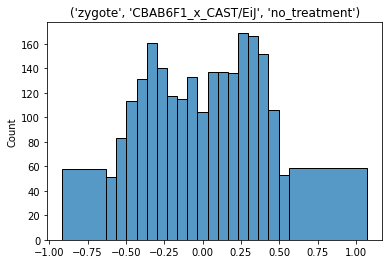

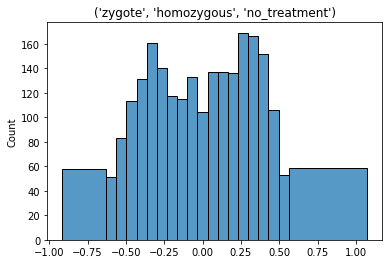

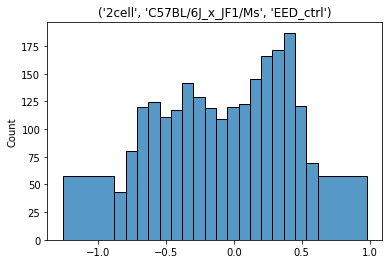

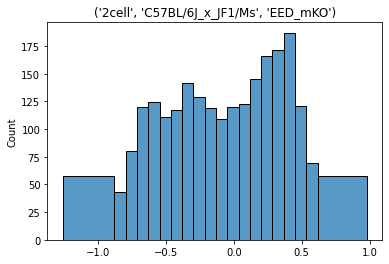

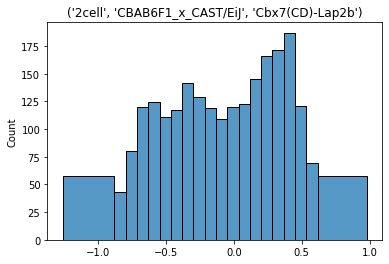

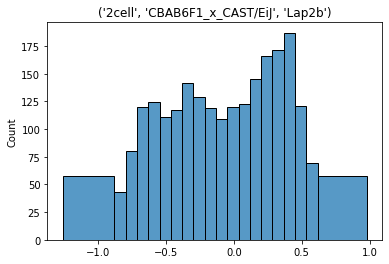

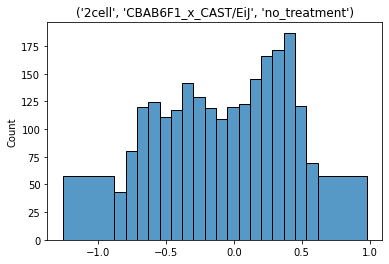

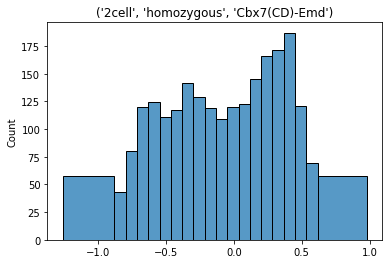

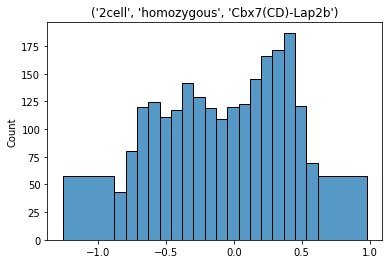

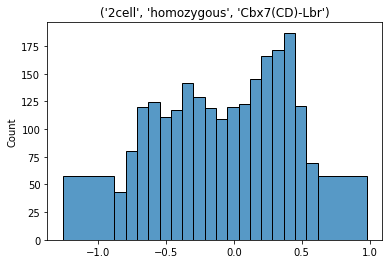

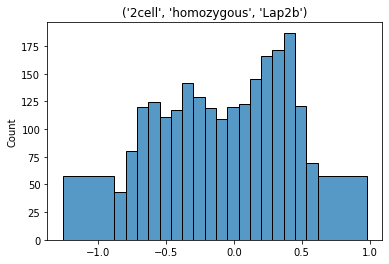

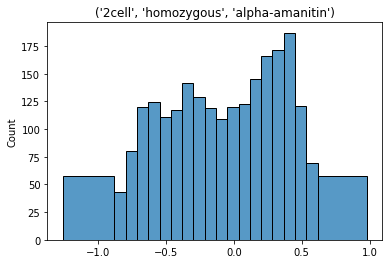

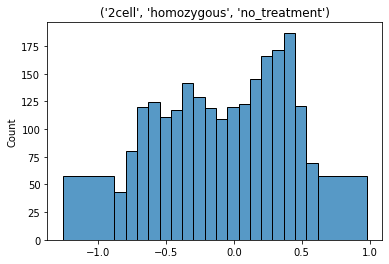

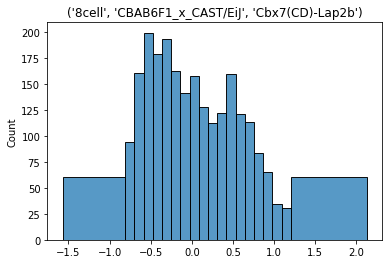

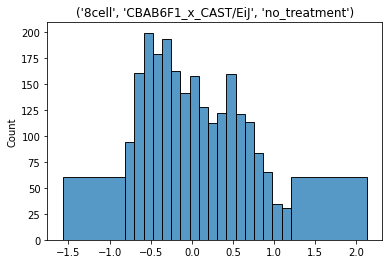

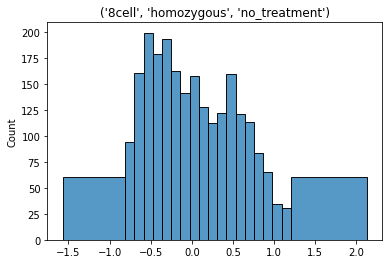

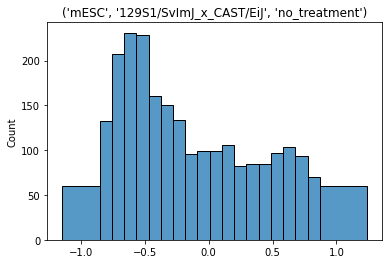

In [153]:
n_bins = 20
min_diag_dist = 3
divide_by_CF = False

results = summarize_data_to_saddle(n_bins, min_diag_dist, divide_by_CF)

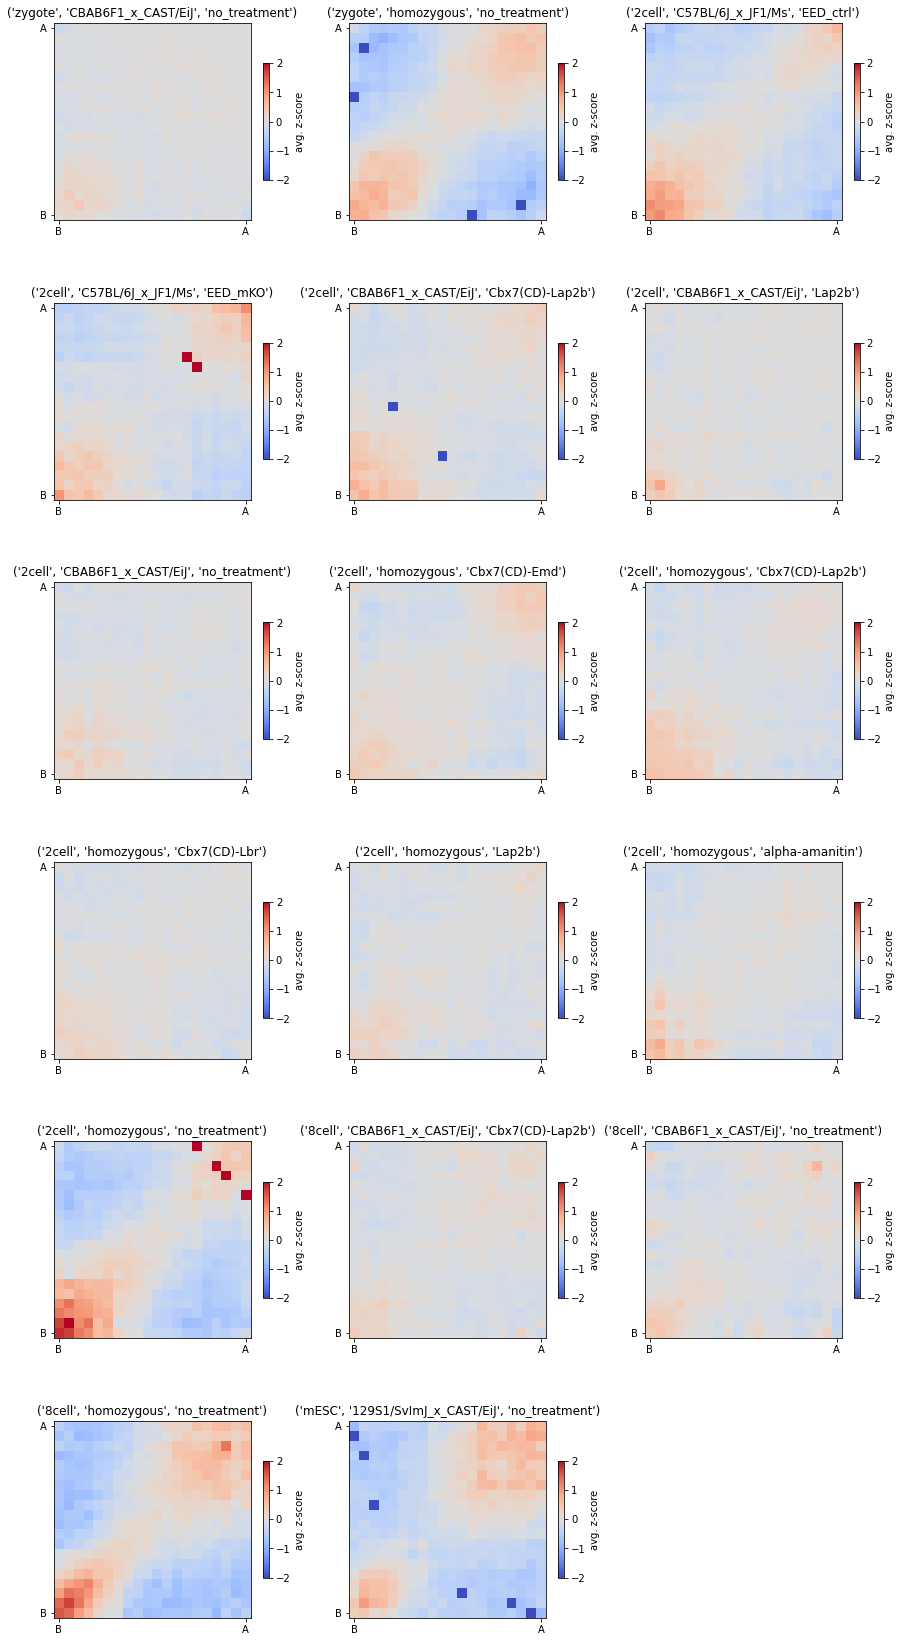

In [156]:
plot_saddle_plot(results, divide_by_CF)

## 9.4 Saddle plots of coordination - separated by CF

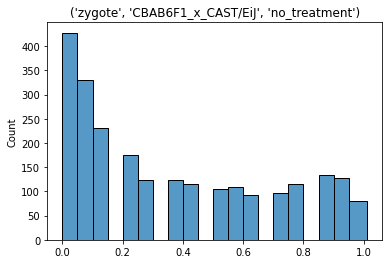

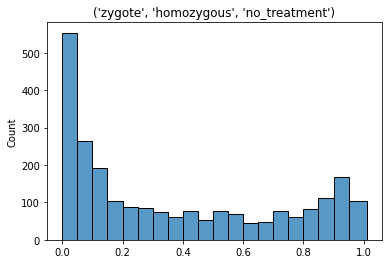

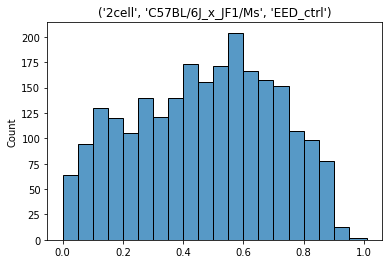

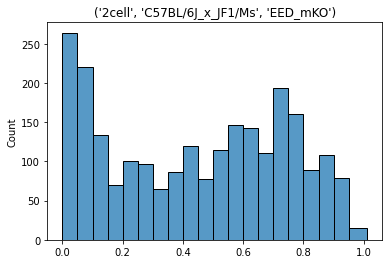

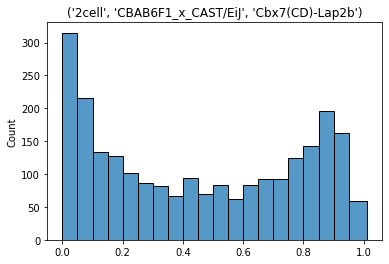

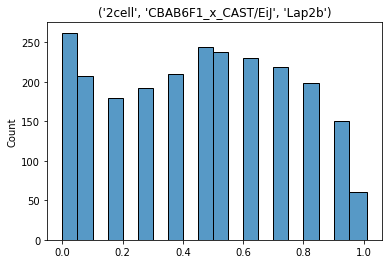

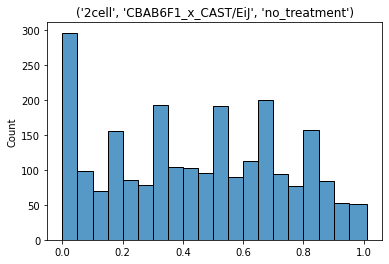

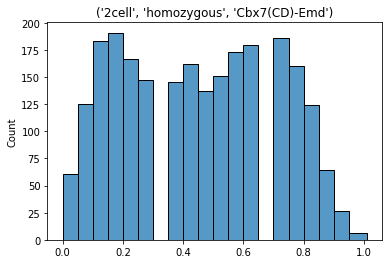

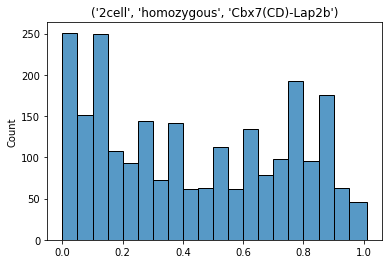

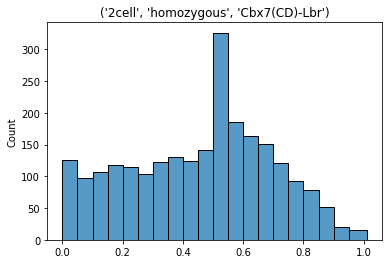

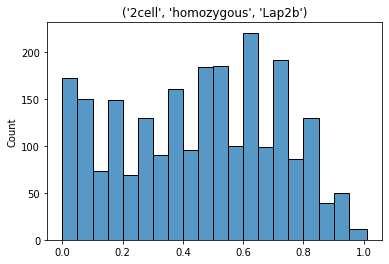

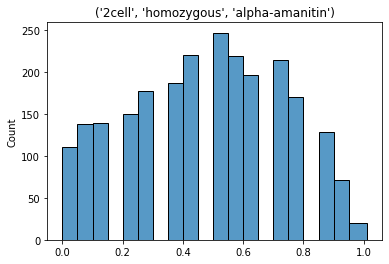

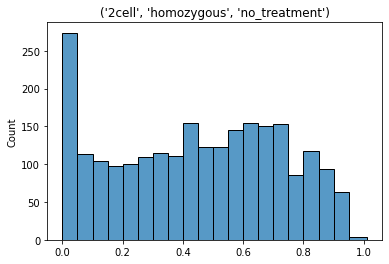

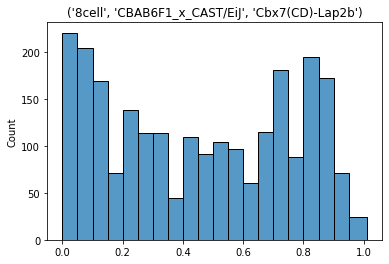

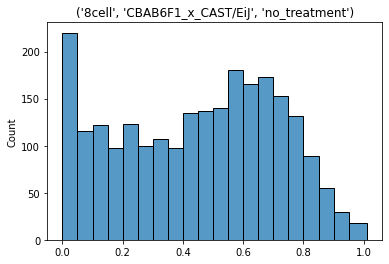

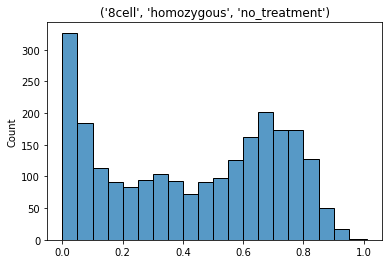

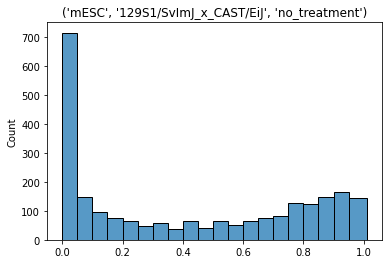

In [157]:
n_bins = 20
min_diag_dist = 3
divide_by_CF = True

results = summarize_data_to_saddle(n_bins, min_diag_dist, divide_by_CF)

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70191/1739254408.py:12: RuntimeWarning: invalid value encountered in true_divide
  p = ax.imshow(R / N, vmin=-2, vmax=2, cmap='coolwarm', origin='lower')


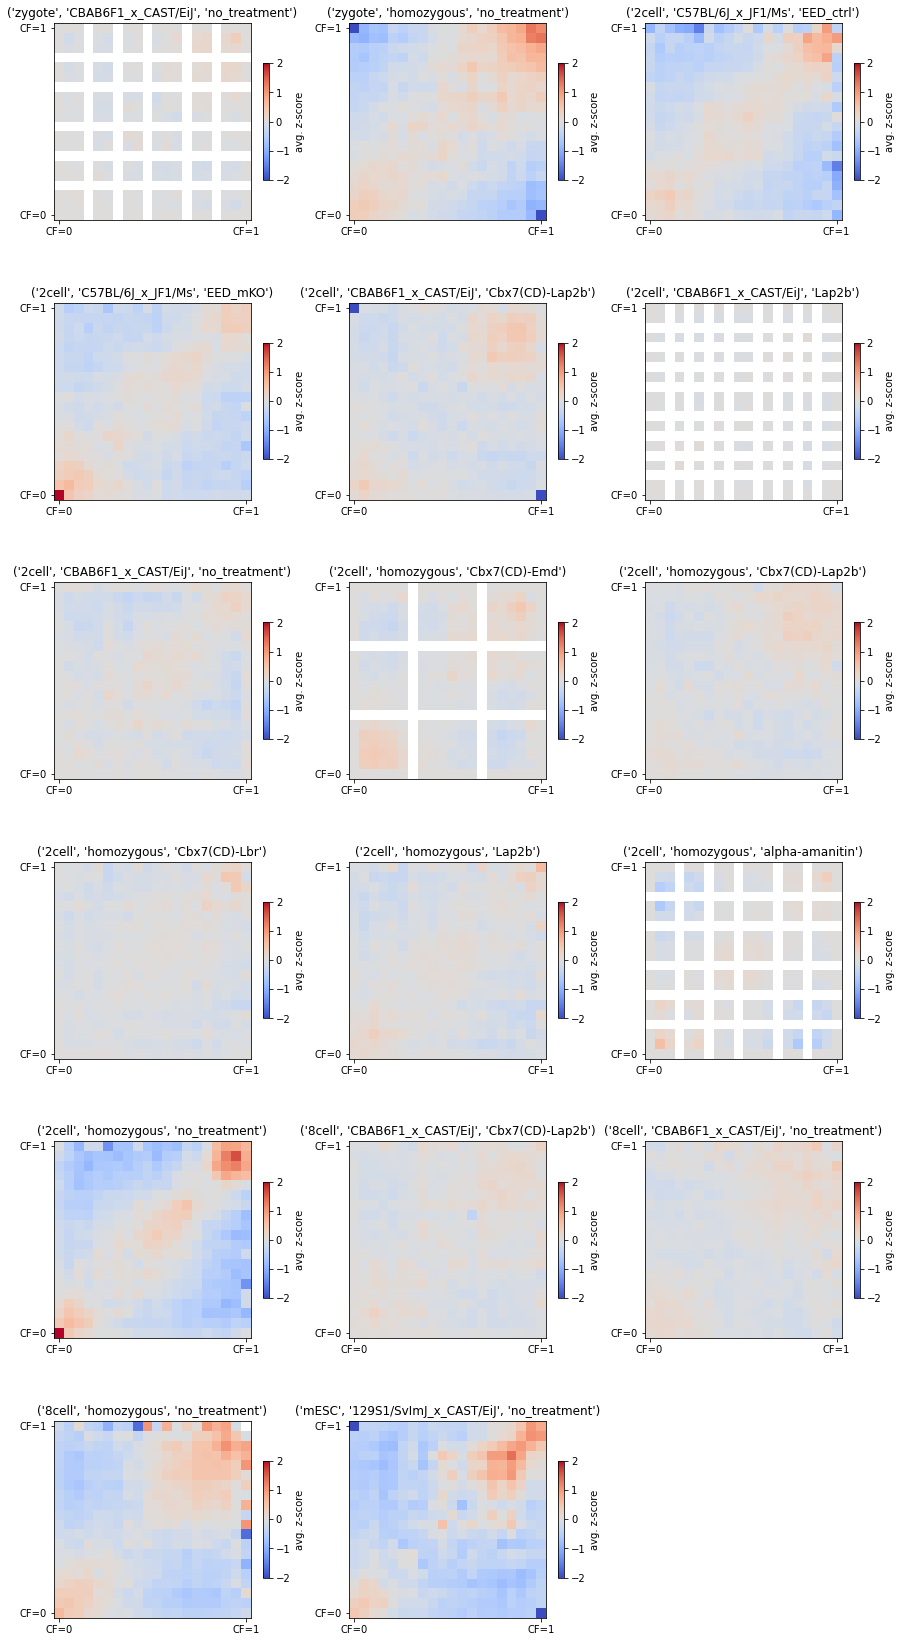

In [158]:
plot_saddle_plot(results, divide_by_CF)

## 9.5 Function to make coordination saddle plot by distance categories

In [162]:
def summarize_data_to_saddle_by_dist(n_bins, n_mb_out, mb_step_size=10, min_diag_dist=3, divide_by_CF=False):

    mb_dist_categories = np.arange(0,n_mb_out,mb_step_size)

    if divide_by_CF:
        separate_outliers = False
    else:
        separate_outliers = True
    low_thresh = 2.5
    high_thresh = 97.5

    results = dict()

    for condition in condition_ls:
        stage = condition[0]
        results[condition] = dict()
        sample = match_stages[stage]

        # select compartment scores (PC1)
        if divide_by_CF:
            C = np.concatenate([contact_freq[condition][c] for c in chrom_order[:-2]])
        else:
            C = np.concatenate([compartments.loc[compartments.chrom==c, sample].values[:len(mapab[c])] for c in chrom_order[:-2]])
        m_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP
        C[~m_ind] = np.nan

        # determine digitized categories
        if separate_outliers:
            outliers = np.nanpercentile(C, [low_thresh, high_thresh])
            bin_edges = np.linspace(outliers[0], outliers[1], n_bins-1)
            bin_edges_ext = np.concatenate([[-np.inf], bin_edges, [np.inf]])
            bin_edges_show = np.concatenate([[np.nanmin(C)], bin_edges, [np.nanmax(C)]])
        elif divide_by_CF:
            bin_edges_show = np.linspace(0, 1, n_bins+1)
            bin_edges_show[-1] = bin_edges_show[-1] + 0.01
            bin_edges_ext = np.copy(bin_edges_show)
        else:
            bin_edges_show = np.linspace(np.nanmin(C), np.nanmax(C), n_bins+1)
            r = np.nanmax(C) - np.nanmin(C)
            bin_edges_show[-1] = bin_edges_show[-1] + 0.01*r
            bin_edges_ext = np.copy(bin_edges_show)
#             bin_edges_ext[-1] += 1

        # show digitized compartment score histogram
        fig, ax = plt.subplots()
        sns.histplot(C, bins=bin_edges_show, ax=ax)
        ax.set_title(condition)
        plt.show()
        plt.close()

        for dist in tqdm(mb_dist_categories):
            bin_start = int((dist*1e6)//BINSIZE)
            bin_end = int(((dist+10)*1e6)//BINSIZE)

            # set up matrices to collect results
            R = np.zeros((n_bins, n_bins))
            N = np.zeros((n_bins, n_bins))

            # iterate chromosomes and add interactions    
            for chrom in chrom_order[:-2]:

                # select data
                M = np.copy(coord_matrices['zscore'][condition][chrom])
                m_ind = mapab[chrom] <= MINMAP
                M[m_ind,:] = np.nan
                M[:,m_ind] = np.nan

                if bin_start >= M.shape[0]:
                    continue
                bin_end_c = max(bin_end, M.shape[0])

                # set data close to diagonal to nan
                for i in range(-min_diag_dist, min_diag_dist):
                    ind = select_kth_diag(M.shape[0], i)
                    M[ind] = np.nan

                # set data outside of selected data range to nan
                if bin_end_c < M.shape[0]:
                    ind = np.triu_indices(M.shape[0], bin_end_c)
                    M[ind] = np.nan
                    ind = np.tril_indices(M.shape[0], bin_end_c)
                    M[ind] = np.nan
                for k in range(-(bin_start+1), bin_start):
                    ind = select_kth_diag(M.shape[0], k)
                    M[ind] = np.nan

                if divide_by_CF:
                    Cchrom = contact_freq[condition][chrom]
                else:
                    Cchrom = compartments.loc[compartments.chrom==chrom, sample].values[:M.shape[0]]

                for i in range(n_bins):
                    ind_i = (Cchrom >= bin_edges_ext[i]) & (Cchrom < bin_edges_ext[i+1])

                    if ind_i.sum() == 0:
                        continue

                    for j in range(n_bins):
                        ind_j = (Cchrom >= bin_edges_ext[j]) & (Cchrom < bin_edges_ext[j+1])

                        if ind_j.sum() == 0:
                            continue


                        R[i,j] += np.nansum(M[ind_i,:][:,ind_j])
                        N[i,j] += np.sum(~np.isnan(M[ind_i,:][:,ind_j]))

            results[condition][dist] = (R, N)
            
    return results

In [172]:
def plot_saddle_plot_by_dist(results, divide_by_CF=False):

    nrow = len(condition_ls)
    ncol = len(results[condition_ls[0]].keys())
    fig, axes = plt.subplots(nrow, ncol, figsize=(3*ncol,3*nrow))

    for irow, condition in enumerate(condition_ls):
        for icol, dist in enumerate(results[condition].keys()):
            ax = axes[irow,icol]

            if icol == 0:
                t = '%s %s (%s)\n%d-%dMb' % (condition[0], condition[2], condition[1], dist, dist+10)
            else:
                t = '%d-%dMb' % (dist, dist+10)
            ax.set_title(t)

            R, N = results[condition][dist]
            p = ax.imshow(R / N, vmin=-2, vmax=2, cmap='coolwarm', origin='lower')
            cbar = plt.colorbar(p, shrink=.5, ax=ax)
            cbar.ax.set_ylabel('avg. z-score')

            ax.set_xticks([0, R.shape[0]-1])
            ax.set_yticks([0, R.shape[0]-1])

            if divide_by_CF:
                ax.set_xticklabels(['CF=0', 'CF=1'])
                ax.set_yticklabels(['CF=0', 'CF=1'])
            else:
                ax.set_xticklabels(['B', 'A'])
                ax.set_yticklabels(['B', 'A'])
                
    plt.show()

## 9.6 Saddle plots of coordination - separated by compartment - by distance

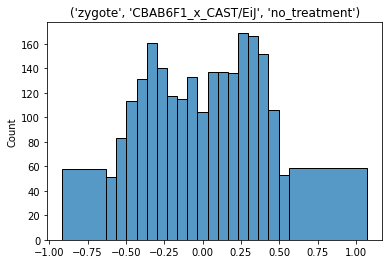

  0%|          | 0/7 [00:00<?, ?it/s]

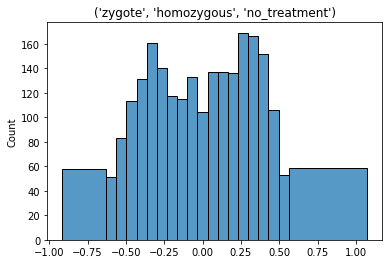

  0%|          | 0/7 [00:00<?, ?it/s]

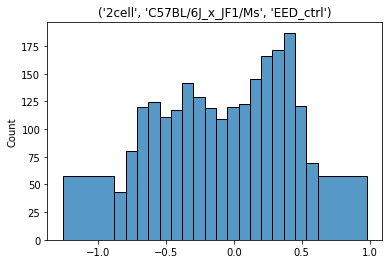

  0%|          | 0/7 [00:00<?, ?it/s]

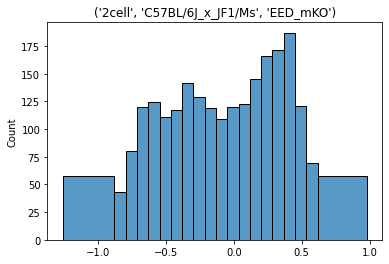

  0%|          | 0/7 [00:00<?, ?it/s]

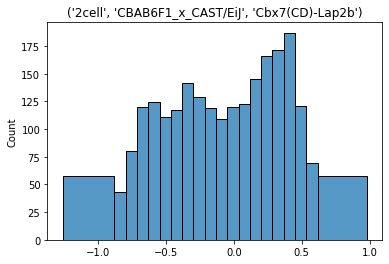

  0%|          | 0/7 [00:00<?, ?it/s]

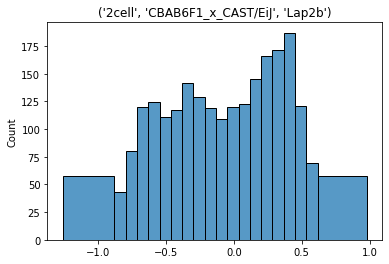

  0%|          | 0/7 [00:00<?, ?it/s]

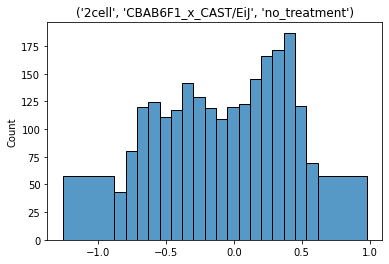

  0%|          | 0/7 [00:00<?, ?it/s]

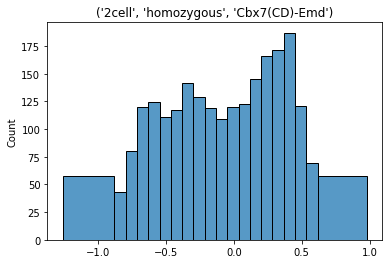

  0%|          | 0/7 [00:00<?, ?it/s]

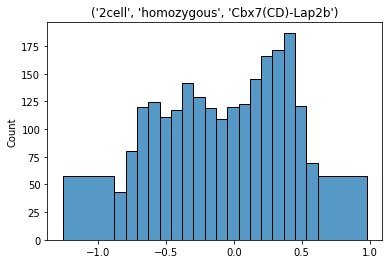

  0%|          | 0/7 [00:00<?, ?it/s]

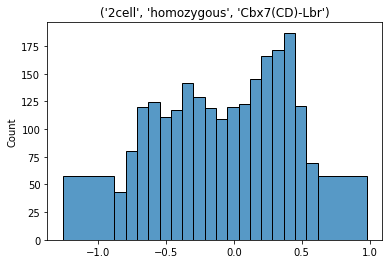

  0%|          | 0/7 [00:00<?, ?it/s]

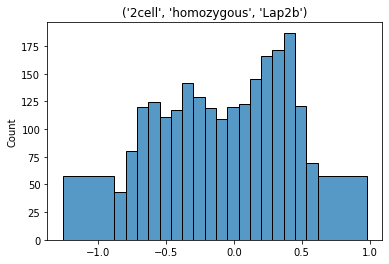

  0%|          | 0/7 [00:00<?, ?it/s]

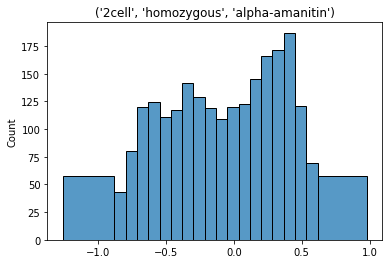

  0%|          | 0/7 [00:00<?, ?it/s]

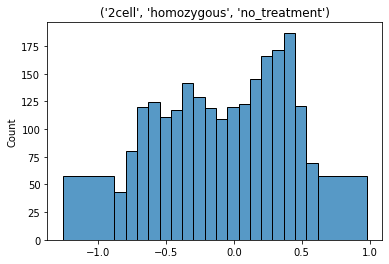

  0%|          | 0/7 [00:00<?, ?it/s]

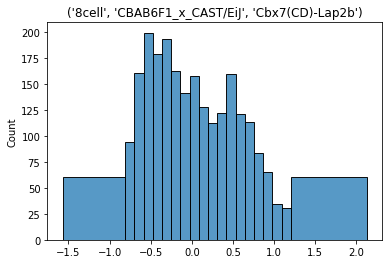

  0%|          | 0/7 [00:00<?, ?it/s]

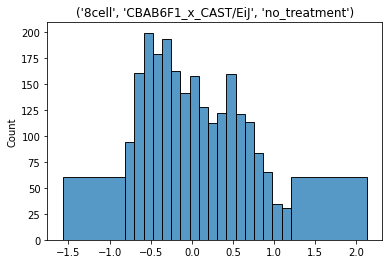

  0%|          | 0/7 [00:00<?, ?it/s]

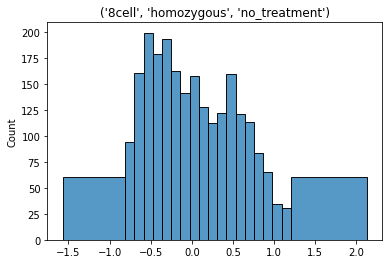

  0%|          | 0/7 [00:00<?, ?it/s]

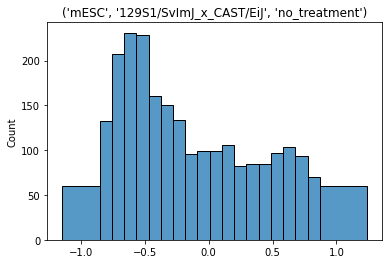

  0%|          | 0/7 [00:00<?, ?it/s]

In [173]:
n_bins = 20
min_diag_dist = 3
n_mb_out = 70
mb_step_size = 10
divide_by_CF = False

results = summarize_data_to_saddle_by_dist(n_bins, n_mb_out, mb_step_size, min_diag_dist, divide_by_CF)

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70191/1820085468.py:18: RuntimeWarning: invalid value encountered in true_divide
  p = ax.imshow(R / N, vmin=-2, vmax=2, cmap='coolwarm', origin='lower')


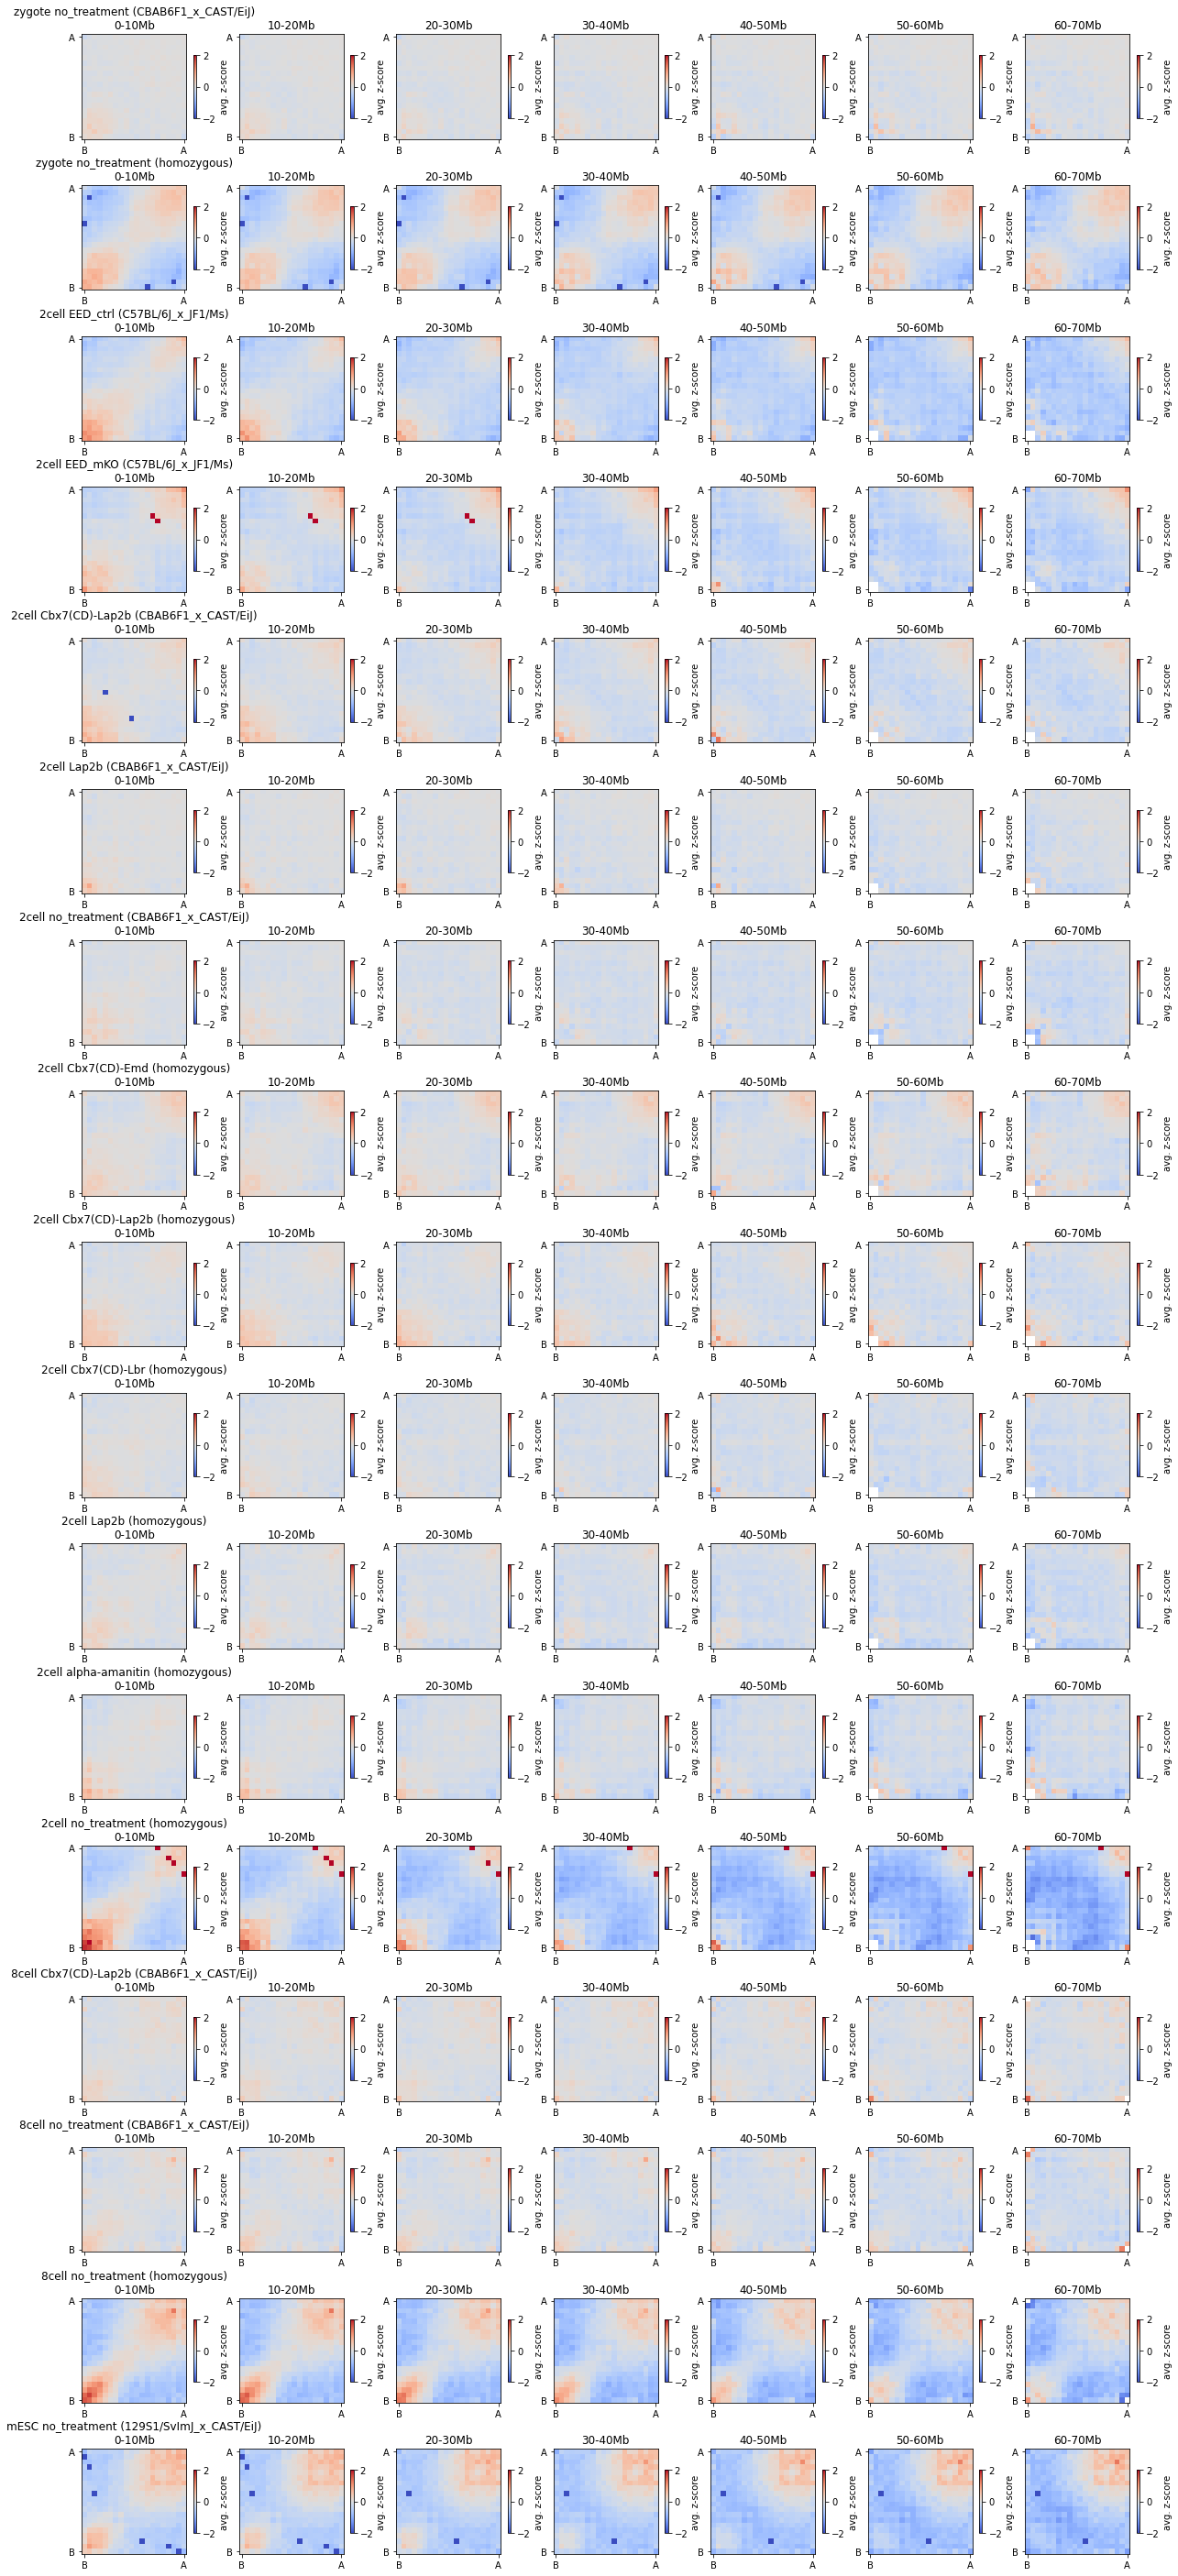

In [174]:
plot_saddle_plot_by_dist(results, divide_by_CF)

## 9.6 Saddle plots of coordination - separated by CF - by distance

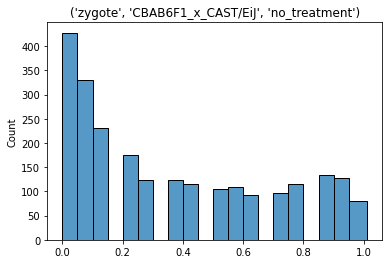

  0%|          | 0/7 [00:00<?, ?it/s]

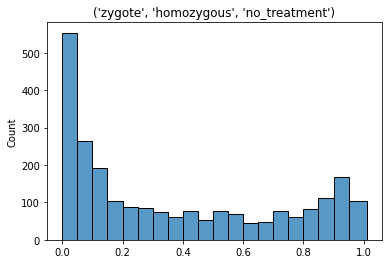

  0%|          | 0/7 [00:00<?, ?it/s]

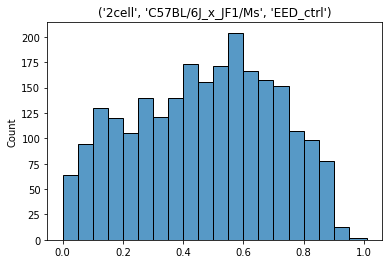

  0%|          | 0/7 [00:00<?, ?it/s]

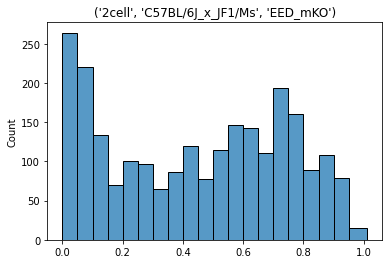

  0%|          | 0/7 [00:00<?, ?it/s]

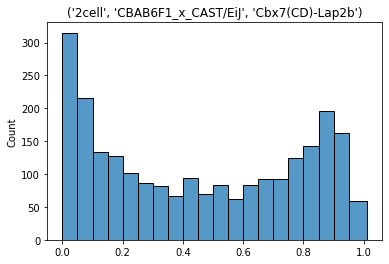

  0%|          | 0/7 [00:00<?, ?it/s]

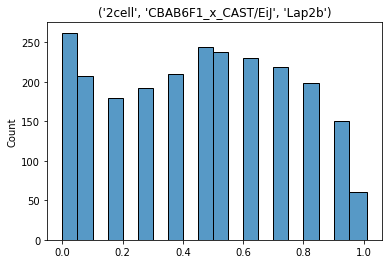

  0%|          | 0/7 [00:00<?, ?it/s]

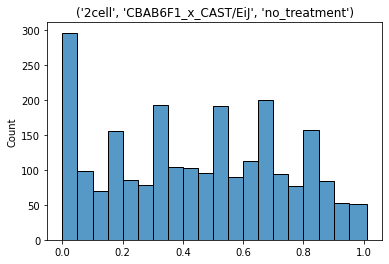

  0%|          | 0/7 [00:00<?, ?it/s]

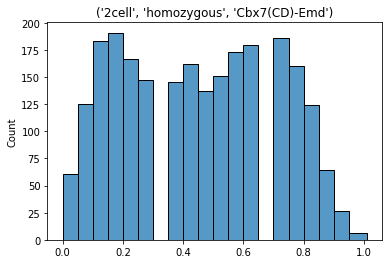

  0%|          | 0/7 [00:00<?, ?it/s]

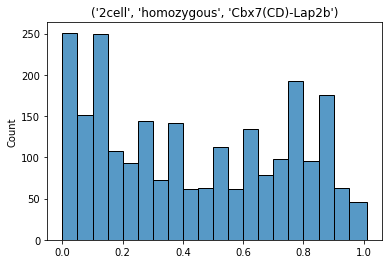

  0%|          | 0/7 [00:00<?, ?it/s]

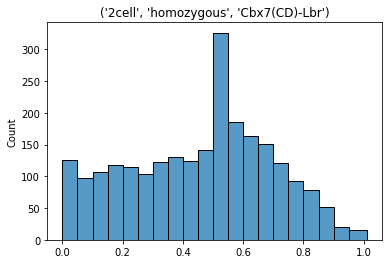

  0%|          | 0/7 [00:00<?, ?it/s]

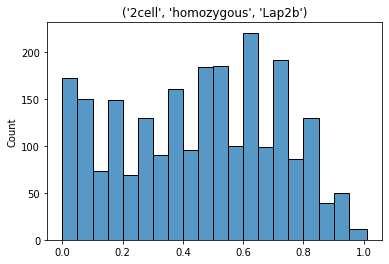

  0%|          | 0/7 [00:00<?, ?it/s]

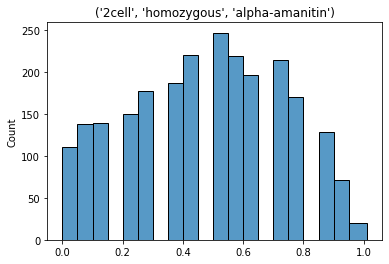

  0%|          | 0/7 [00:00<?, ?it/s]

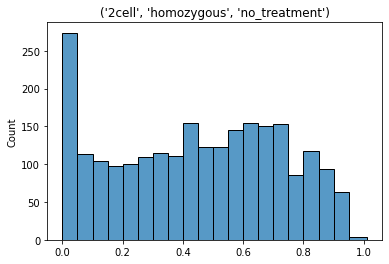

  0%|          | 0/7 [00:00<?, ?it/s]

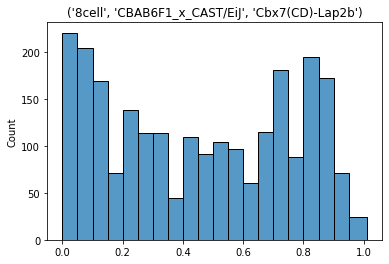

  0%|          | 0/7 [00:00<?, ?it/s]

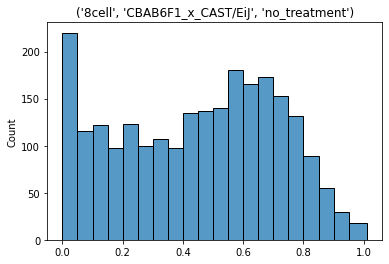

  0%|          | 0/7 [00:00<?, ?it/s]

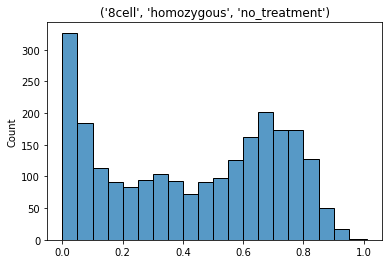

  0%|          | 0/7 [00:00<?, ?it/s]

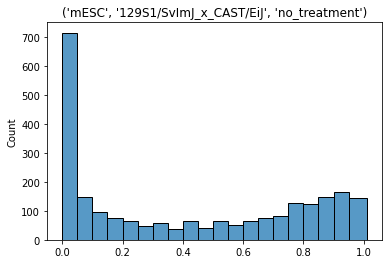

  0%|          | 0/7 [00:00<?, ?it/s]

In [175]:
n_bins = 20
min_diag_dist = 3
n_mb_out = 70
mb_step_size = 10
divide_by_CF = True

results = summarize_data_to_saddle_by_dist(n_bins, n_mb_out, mb_step_size, min_diag_dist, divide_by_CF)

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_70191/1820085468.py:18: RuntimeWarning: invalid value encountered in true_divide
  p = ax.imshow(R / N, vmin=-2, vmax=2, cmap='coolwarm', origin='lower')


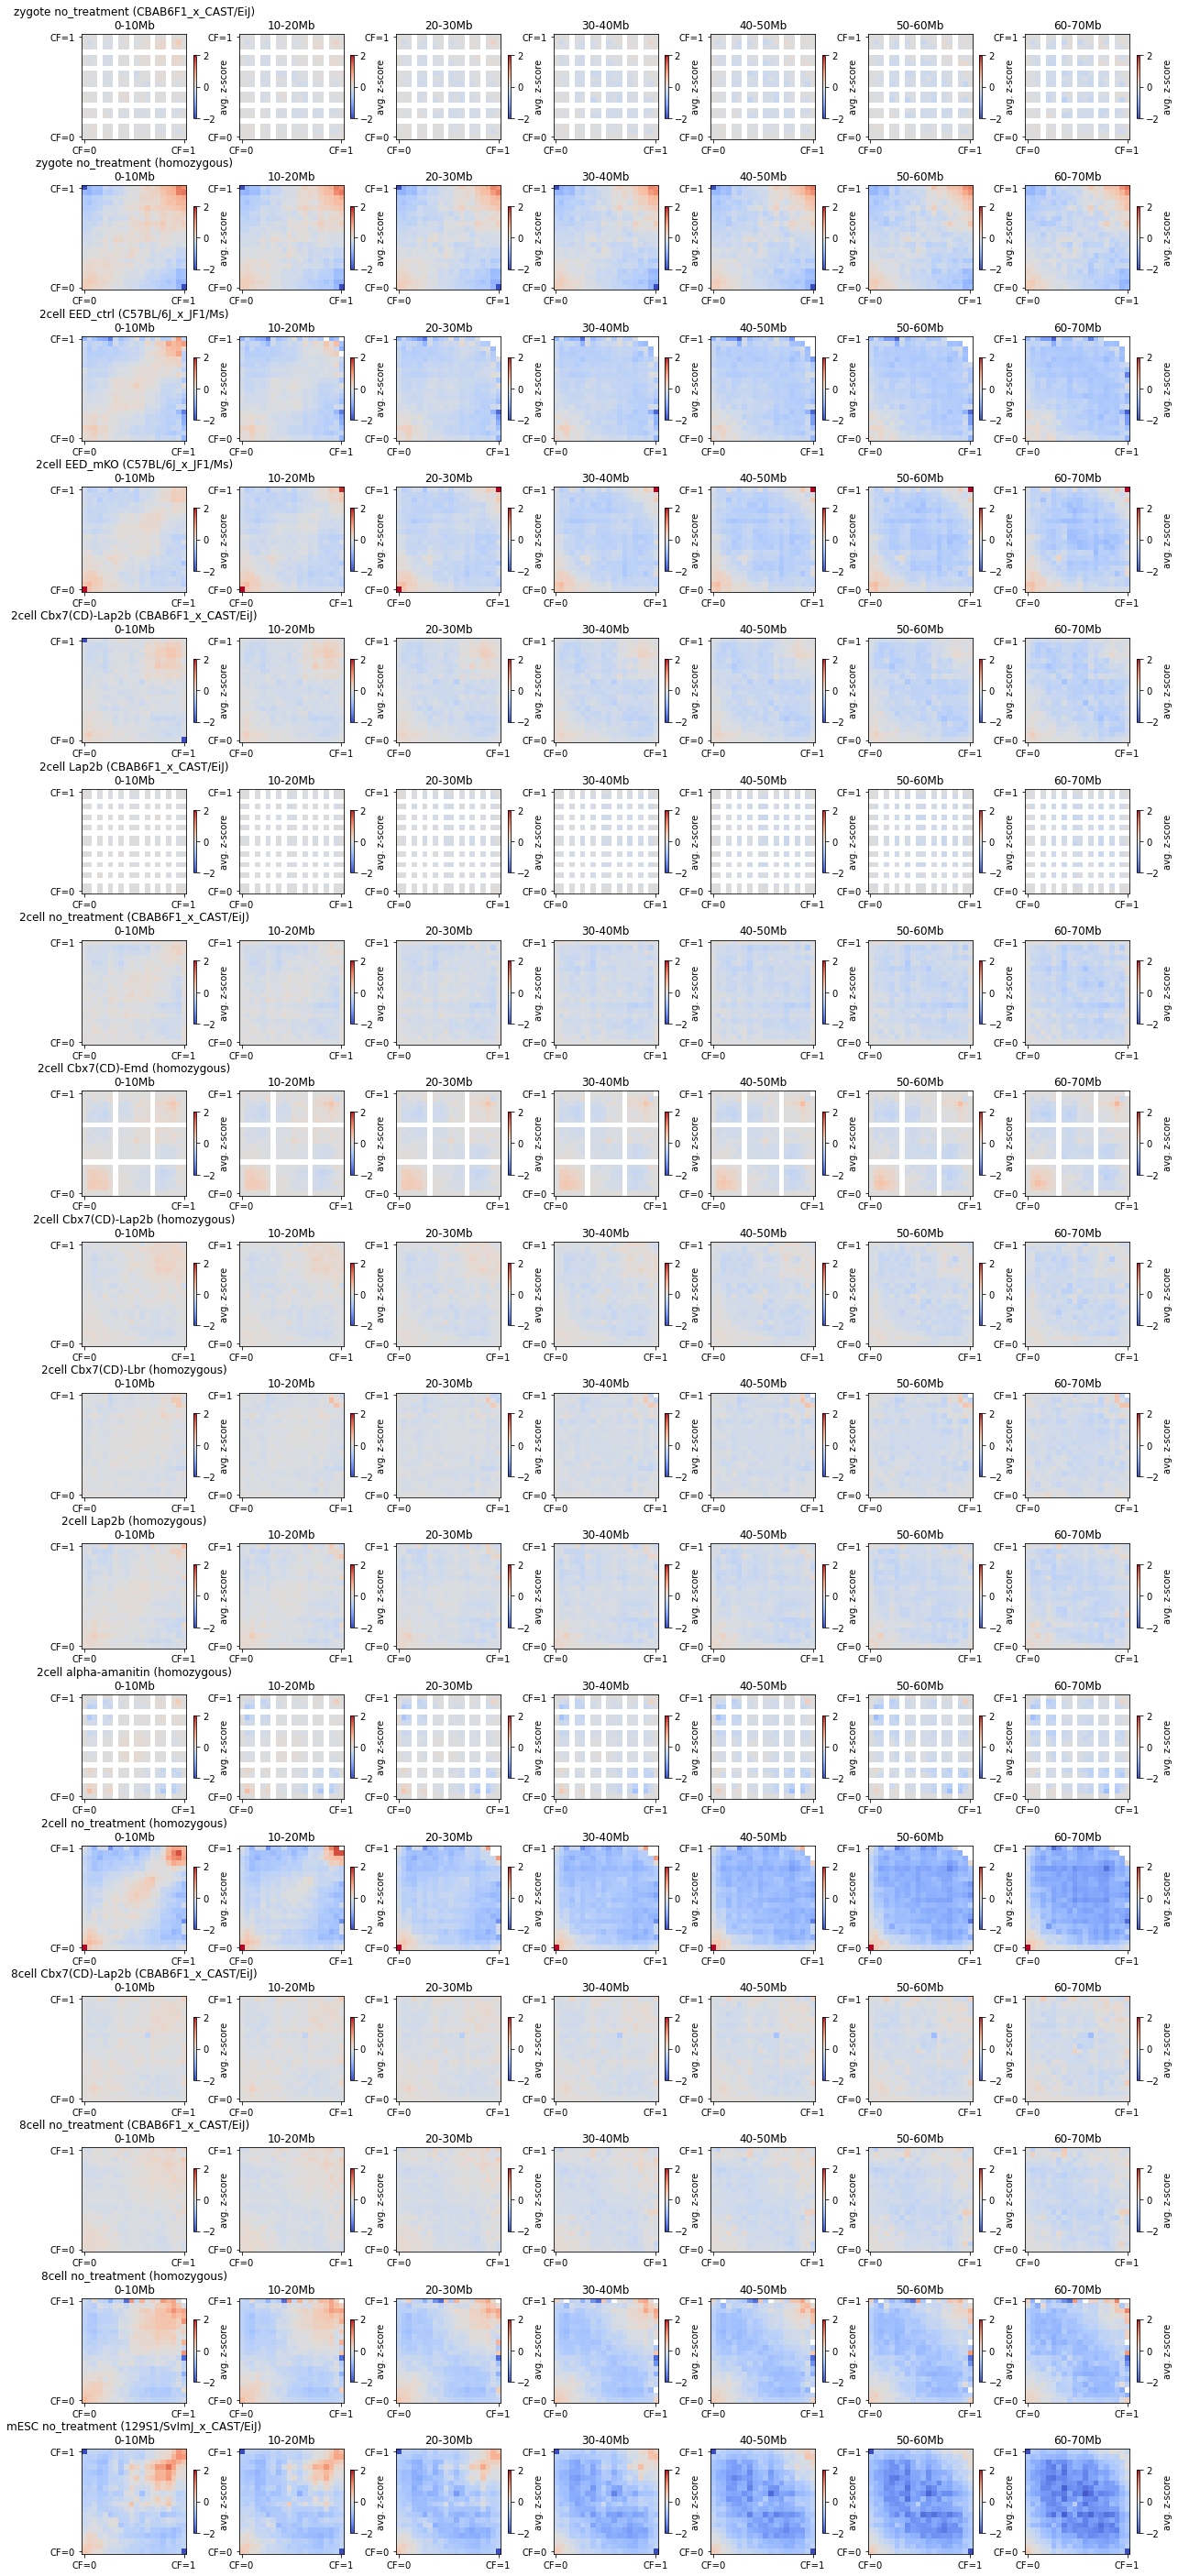

In [176]:
plot_saddle_plot_by_dist(results, divide_by_CF)